# Flooding likelihood
TODO: to find out what is the expected probability of flooding given rainfall intensities (total daily rainfall, maximum 30 min, maximum 60 min, maximum 120 min)

In [10]:
import pandas as pd
import numpy as np
import importlib
import os
import matplotlib.pyplot as plt
import pymc as pm
import pytensor.tensor as at
import arviz as az
from scipy.stats.mstats import mquantiles
import pickle
import helper_functions.bayesian_flood_probability
import helper_functions.goodness_of_fit_metrics
import helper_functions.utils
importlib.reload(helper_functions.bayesian_flood_probability)
importlib.reload(helper_functions.goodness_of_fit_metrics)
importlib.reload(helper_functions.utils)
import helper_functions.bayesian_flood_probability as BayesFlood
import helper_functions.goodness_of_fit_metrics as flood_metrics
import helper_functions.utils as utils

# Import historical weather and flood data

In [2]:
# imported_data_dir = os.path.join(os.getcwd(),"Exported_Data")
imported_data_dir = os.path.join(os.getcwd(),"Flood_Weather_Data")
weather_df = pd.read_csv(os.path.join(imported_data_dir,"historical_weather.csv"))
# filter weather daya from 2014 to 2024
weather_df = weather_df[(weather_df['year'] > 2013) & (weather_df['year']< 2025)]
weather_df

,station,year,month,day,daily rainfall total (mm),highest 30 min rainfall (mm),highest 60 min rainfall (mm),highest 120 min rainfall (mm),mean temperature (Â°c),maximum temperature (Â°c),minimum temperature (Â°c),mean wind speed (km/h),max wind speed (km/h),Date,drainage_catchment
7305,Paya Lebar,2014.0,1.0,1.0,0.0,NaN,NaN,NaN,NaN,29.5,24.8,15.8,35.3,2014-01-01,Punggol
7306,Paya Lebar,2014.0,1.0,2.0,0.0,NaN,NaN,NaN,NaN,31.7,25.0,16.5,37.1,2014-01-02,Punggol
7307,Paya Lebar,2014.0,1.0,3.0,2.2,NaN,NaN,NaN,NaN,31.1,25.1,14.9,33.5,2014-01-03,Punggol
7308,Paya Lebar,2014.0,1.0,4.0,0.6,NaN,NaN,NaN,NaN,32.3,23.7,8.9,35.3,2014-01-04,Punggol
7309,Paya Lebar,2014.0,1.0,5.0,10.5,NaN,NaN,NaN,NaN,27.0,23.8,11.9,33.5,2014-01-05,Punggol
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
462996,Pasir Ris (Central),2024.0,12.0,27.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,2024-12-27,Punggol
462997,Pasir Ris (Central),2024.0,12.0,28.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,2024-12-28,Punggol
462998,Pasir Ris (Central),2024.0,12.0,29.0,0.2,0.2,0.2,0.2,NaN,NaN,NaN,NaN,NaN,2024-12-29,Punggol
462999,Pasir Ris (Central),2024.0,12.0,30.0,31.0,14.0,25.0,30.8,NaN,NaN,NaN,NaN,NaN,2024-12-30,Punggol


In [3]:
flood_df = pd.read_csv(os.path.join(imported_data_dir,"precipitation_levels_during_flood_events.csv"))
flood_df

,flooded_location,responses_found,matched_location,latitude,longitude,closest_weather_stn,mean_pr,daily rainfall total (mm),highest 30 min rainfall (mm),highest 60 min rainfall (mm),highest 120 min rainfall (mm),drainage_catchment,time
0,Yishun MRT,9,ATM DBS YISHUN MRT STATION,1.429525,103.834995,Yishun,17.395082,45.0,40.8,44.0,44.2,Woodlands,2014-03-20
1,2 KAKI BUKIT ROAD 3,1,2 KAKI BUKIT ROAD 3 SINGAPORE 417817,1.337334,103.901943,Tai Seng,7.993548,25.0,21.0,25.0,25.0,Geylang,2014-04-04
2,PSC Building,1,PSC BUILDING,1.328863,103.706189,Boon Lay (West),14.574603,89.5,49.5,83.0,89.0,Jurong,2014-04-23
3,21229 (bus stop),1,21229 (BUS STOP),1.342064,103.716020,Jurong (North),14.574603,65.4,51.6,63.8,65.4,Jurong,2014-04-23
4,Tengah Flyover,1,TENGAH FLYOVER,1.363822,103.707043,Jurong (North),22.195238,92.6,50.2,78.4,92.2,Kranji,2014-05-16
...,...,...,...,...,...,...,...,...,...,...,...,...,...
215,SENNETT ESTATE,1182,SENNETT ESTATE,1.332078,103.872969,Serangoon,49.040000,66.8,34.6,51.6,60.2,Geylang,2024-11-22
216,59229 (BUS STOP),1,59229 (BUS STOP),1.439016,103.834164,Yishun,49.040000,78.6,46.8,61.5,70.2,Woodlands,2024-11-22
217,SEMBAWANG GOD OF WEALTH TEMPLE,1,SEMBAWANG GOD OF WEALTH TEMPLE,1.460803,103.811104,Admiralty West,49.040000,106.4,35.8,70.0,93.8,Woodlands,2024-11-22
218,Dunearn Road,77,DUNEARN ROAD / WHITLEY ROAD - ERP(44),1.321188,103.825058,Bukit Timah,44.837209,136.2,65.0,98.0,131.8,Bukit Timah,2024-12-29


### Flooding likelihood per drainage catchment
Divide floods into their respective drainage catchments and date

In [4]:
flood_drainage_catchment = {x:y for x, y in flood_df.groupby('drainage_catchment',as_index=False)}
print(list(flood_drainage_catchment))
flood_drainage_catchment['Bukit Timah']

['Bukit Timah', 'Changi', 'Geylang', 'Jurong', 'Kallang', 'Kranji', 'Pandan', 'Punggol', 'Singapore River', 'Stamford Marina', 'Woodlands']


,flooded_location,responses_found,matched_location,latitude,longitude,closest_weather_stn,mean_pr,daily rainfall total (mm),highest 30 min rainfall (mm),highest 60 min rainfall (mm),highest 120 min rainfall (mm),drainage_catchment,time
11,Mackenzie Road,1,MACKENZIE ROAD,1.305873,103.848002,Dhoby Ghaut,33.603333,95.8,49.4,84.8,95.6,Bukit Timah,2014-07-29
13,Bassein Road,1,BASSEIN ROAD,1.323316,103.848088,Whampoa,33.603333,52.2,22.2,43.4,50.6,Bukit Timah,2014-07-29
21,40099 (bus stop),1,40099 (BUS STOP),1.321852,103.823440,Bukit Timah,44.081356,80.0,40.0,59.2,60.4,Bukit Timah,2014-11-08
51,Pek Kio CC,1,PEK KIO COMMUNITY CENTRE,1.313059,103.851374,Whampoa,29.008333,63.4,48.8,63.0,63.4,Bukit Timah,2015-12-11
52,Balestier Point,1,BALESTIER POINT,1.322812,103.852026,Whampoa,29.008333,63.4,48.8,63.0,63.4,Bukit Timah,2015-12-11
53,50199 (Bus Stop),1,50199 (BUS STOP),1.324968,103.850509,Whampoa,29.008333,63.4,48.8,63.0,63.4,Bukit Timah,2015-12-11
70,Newton Circus,2,NEWTON CIRCUS,1.313224,103.838945,Newton,34.901754,62.4,44.8,56.6,60.0,Bukit Timah,2016-12-24
71,Balmoral Road,1,BALMORAL ROAD,1.313244,103.830181,Newton,34.901754,62.4,44.8,56.6,60.0,Bukit Timah,2016-12-24
72,Cairnhill Road,2,CAIRNHILL ROAD,1.308031,103.836841,Newton,34.901754,62.4,44.8,56.6,60.0,Bukit Timah,2016-12-24
73,Stevens Road,1,STEVENS ROAD,1.313170,103.828976,Newton,34.901754,62.4,44.8,56.6,60.0,Bukit Timah,2016-12-24


### Split weather dataframe into their drainage catchments

In [5]:
weather_drainage_catchment = {x:y for x, y in weather_df.groupby('drainage_catchment',as_index=False)}
list(weather_drainage_catchment)
weather_drainage_catchment['Bukit Timah']

,station,year,month,day,daily rainfall total (mm),highest 30 min rainfall (mm),highest 60 min rainfall (mm),highest 120 min rainfall (mm),mean temperature (Â°c),maximum temperature (Â°c),minimum temperature (Â°c),mean wind speed (km/h),max wind speed (km/h),Date,drainage_catchment
18628,Macritchie Reservoir,2014.0,1.0,1.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,2014-01-01,Bukit Timah
18629,Macritchie Reservoir,2014.0,1.0,2.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,2014-01-02,Bukit Timah
18630,Macritchie Reservoir,2014.0,1.0,3.0,1.4,1.0,1.4,1.4,NaN,NaN,NaN,NaN,NaN,2014-01-03,Bukit Timah
18631,Macritchie Reservoir,2014.0,1.0,4.0,11.4,7.0,7.8,7.8,NaN,NaN,NaN,NaN,NaN,2014-01-04,Bukit Timah
18632,Macritchie Reservoir,2014.0,1.0,5.0,6.6,1.6,2.8,4.6,NaN,NaN,NaN,NaN,NaN,2014-01-05,Bukit Timah
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
447561,Bukit Timah,2024.0,12.0,27.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,2024-12-27,Bukit Timah
447562,Bukit Timah,2024.0,12.0,28.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,2024-12-28,Bukit Timah
447563,Bukit Timah,2024.0,12.0,29.0,136.2,65.0,98.0,131.8,NaN,NaN,NaN,NaN,NaN,2024-12-29,Bukit Timah
447564,Bukit Timah,2024.0,12.0,30.0,4.0,1.8,1.8,2.2,NaN,NaN,NaN,NaN,NaN,2024-12-30,Bukit Timah


# Prepare data sets
- Outputs per drainage catchment:
    - binary flood occurrences (nx1)
    - precipitation ranges that lead to flood (nx4): where 1st column = total ppt, 2nd column = max 30, 3rd column = max 60, 4th column = max 120

In [ ]:
# non_flood_dates = BayesFlood.get_non_flood_dates(weather_drainage_catchment['Bukit Timah']['Date'].to_list(), 
#                     flood_drainage_catchment['Bukit Timah']['time'].to_list())
# BayesFlood.subset_nonflood_weather(weather_drainage_catchment['Bukit Timah'],non_flood_dates)

,Date,year,month,day,daily rainfall total (mm),highest 30 min rainfall (mm),highest 60 min rainfall (mm),highest 120 min rainfall (mm),mean temperature (degC),maximum temperature (degC),minimum temperature (degC),mean wind speed (km/h),max wind speed (km/h)
0,2014-01-01,2014.0,1.0,1.0,0.00,0.00,0.00,0.00,26.4,29.0,24.4,7.4,40.3
1,2014-01-02,2014.0,1.0,2.0,0.00,0.00,0.00,0.00,27.1,30.6,25.0,7.1,35.6
2,2014-01-03,2014.0,1.0,3.0,0.72,0.48,0.60,0.64,26.7,30.5,25.1,6.7,37.8
3,2014-01-04,2014.0,1.0,4.0,17.08,13.96,15.96,16.04,26.5,31.9,24.2,4.8,34.9
4,2014-01-05,2014.0,1.0,5.0,6.44,1.72,2.68,4.32,24.7,25.9,23.5,5.9,31.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3628,2023-12-27,2023.0,12.0,27.0,9.70,3.05,3.60,4.45,25.6,29.0,24.2,5.7,28.9
3629,2023-12-28,2023.0,12.0,28.0,33.15,15.15,16.95,20.85,26.0,30.8,24.1,5.1,39.3
3630,2023-12-29,2023.0,12.0,29.0,4.95,3.70,4.35,5.20,27.2,31.0,25.0,5.7,29.4
3631,2023-12-30,2023.0,12.0,30.0,1.80,1.20,1.30,1.50,27.2,29.8,25.8,5.6,33.9


### Get non flood data

In [6]:
non_flood_data = dict()
for drainage_name in list(weather_drainage_catchment):
    non_flood_dates = BayesFlood.get_non_flood_dates(weather_drainage_catchment[drainage_name]['Date'].to_list(), 
                        list(flood_drainage_catchment[drainage_name]))
    df = BayesFlood.subset_nonflood_weather(weather_drainage_catchment[drainage_name],non_flood_dates)
    non_flood_data[drainage_name] = df[['daily rainfall total (mm)', 'highest 30 min rainfall (mm)','highest 60 min rainfall (mm)','highest 120 min rainfall (mm)']]
non_flood_data

{'Bukit Timah':       daily rainfall total (mm)  highest 30 min rainfall (mm)  \
 0                          0.00                          0.00   
 1                          0.00                          0.00   
 2                          0.72                          0.48   
 3                         17.08                         13.96   
 4                          6.44                          1.72   
 ...                         ...                           ...   
 4013                       0.10                          0.10   
 4014                       0.00                          0.00   
 4015                     104.55                         50.90   
 4016                       7.55                          3.70   
 4017                      10.65                          6.20   
 
       highest 60 min rainfall (mm)  highest 120 min rainfall (mm)  
 0                             0.00                           0.00  
 1                             0.00                  

### Get flood data

In [7]:
flood_data = dict()
for drainage_name,df in flood_drainage_catchment.items():
    flood_data[drainage_name] = df[['daily rainfall total (mm)', 'highest 30 min rainfall (mm)','highest 60 min rainfall (mm)','highest 120 min rainfall (mm)']]
flood_data

{'Bukit Timah':      daily rainfall total (mm)  highest 30 min rainfall (mm)  \
 11                        95.8                          49.4   
 13                        52.2                          22.2   
 21                        80.0                          40.0   
 51                        63.4                          48.8   
 52                        63.4                          48.8   
 53                        63.4                          48.8   
 70                        62.4                          44.8   
 71                        62.4                          44.8   
 72                        62.4                          44.8   
 73                        62.4                          44.8   
 84                        44.2                          35.2   
 87                        76.8                          51.2   
 90                        72.8                          51.0   
 102                       80.4                          34.6   
 103      

### Combine non flood and flood data, and create binary vector for flood occurrence

In [8]:
flood_occurrences_dict = BayesFlood.get_binary_flood_occurrence(flood_data, non_flood_data)
flood_occurrences_dict  

{'Bukit Timah': {'daily rainfall total (mm)': (array([1, 1, 1, ..., 0, 0, 0]),
   array([ 95.8 ,  52.2 ,  80.  , ..., 104.55,   7.55,  10.65])),
  'highest 30 min rainfall (mm)': (array([1, 1, 1, ..., 0, 0, 0]),
   array([49.4, 22.2, 40. , ..., 50.9,  3.7,  6.2])),
  'highest 60 min rainfall (mm)': (array([1, 1, 1, ..., 0, 0, 0]),
   array([84.8 , 43.4 , 59.2 , ..., 74.25,  4.85,  7.8 ])),
  'highest 120 min rainfall (mm)': (array([1, 1, 1, ..., 0, 0, 0]),
   array([ 95.6 ,  50.6 ,  60.4 , ..., 101.25,   5.2 ,   9.15]))},
 'Changi': {'daily rainfall total (mm)': (array([1, 1, 1, ..., 0, 0, 0]),
   array([40.4 , 64.4 , 22.4 , ...,  6.4 , 30.75, 18.55])),
  'highest 30 min rainfall (mm)': (array([1, 1, 1, ..., 0, 0, 0]),
   array([18.  , 55.2 , 12.2 , ...,  5.2 , 16.45, 14.55])),
  'highest 60 min rainfall (mm)': (array([1, 1, 1, ..., 0, 0, 0]),
   array([26.  , 60.8 , 12.4 , ...,  5.75, 25.65, 16.15])),
  'highest 120 min rainfall (mm)': (array([1, 1, 1, ..., 0, 0, 0]),
   array([39.2 ,

# Expected probability of flood per drainage catchment

Bukit Timah (daily rainfall total (mm)),67.40606060606059


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [beta]
>Metropolis: [alpha]


Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 84 seconds.


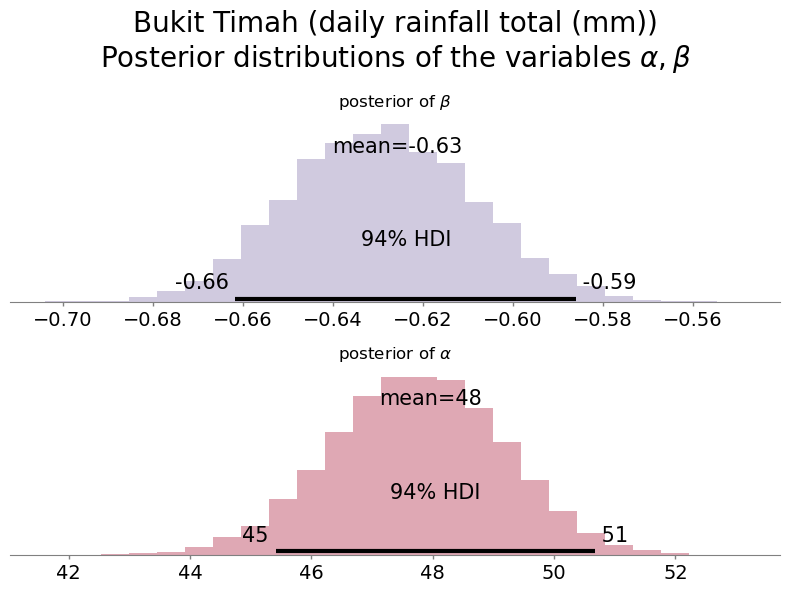

Bukit Timah (highest 30 min rainfall (mm)),38.34545454545455


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [beta]
>Metropolis: [alpha]


Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 79 seconds.


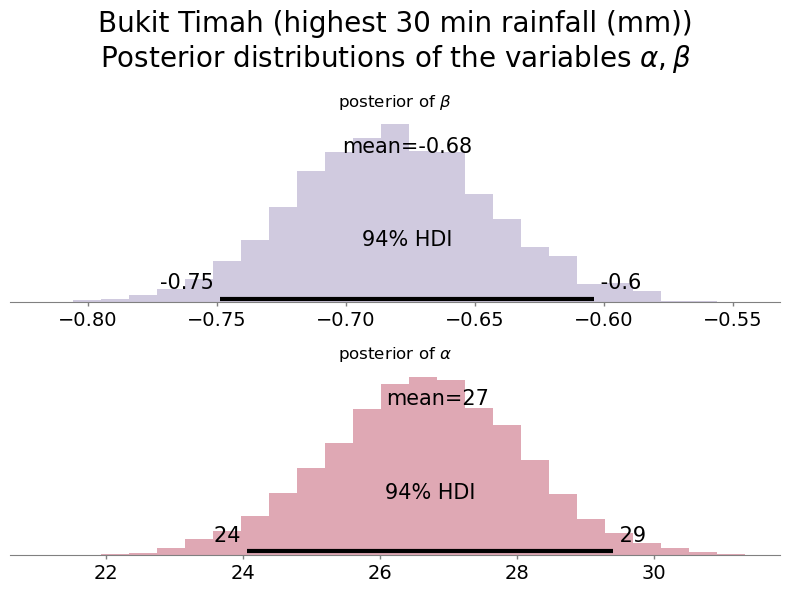

Bukit Timah (highest 60 min rainfall (mm)),54.981818181818184


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [beta]
>Metropolis: [alpha]


Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 80 seconds.


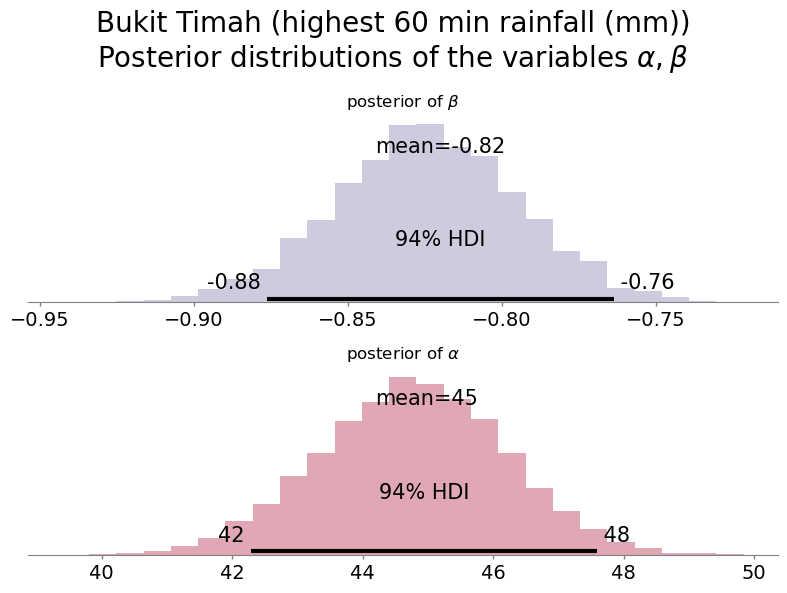

Bukit Timah (highest 120 min rainfall (mm)),61.28484848484848


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [beta]
>Metropolis: [alpha]


Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 82 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details


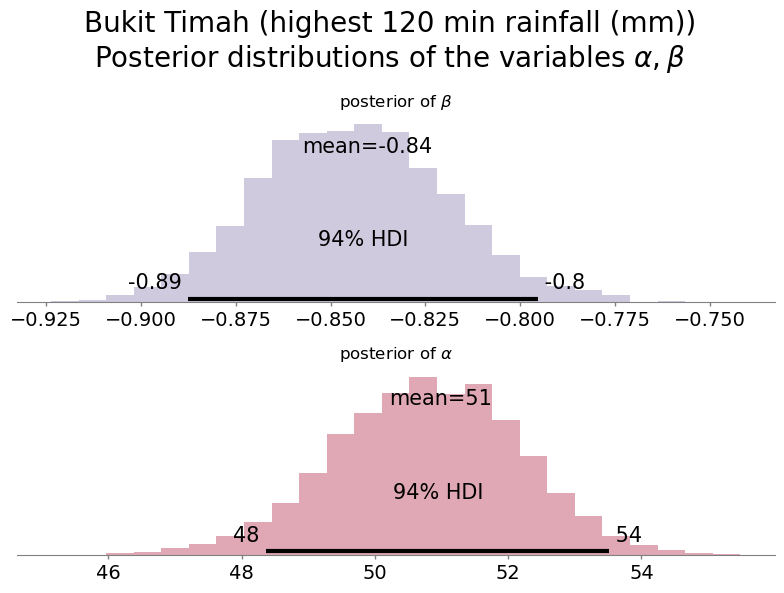

Changi (daily rainfall total (mm)),74.6


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [beta]
>Metropolis: [alpha]


Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 83 seconds.


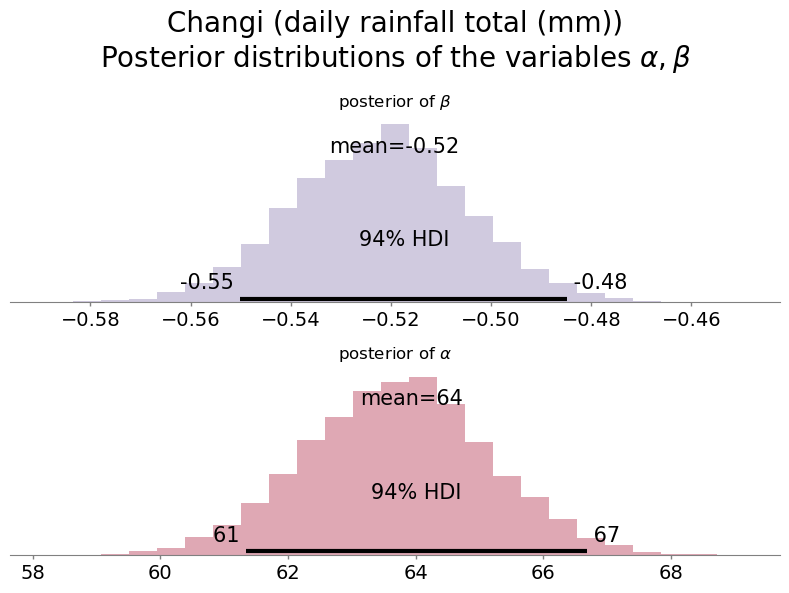

Changi (highest 30 min rainfall (mm)),36.11999999999999


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [beta]
>Metropolis: [alpha]


Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 76 seconds.


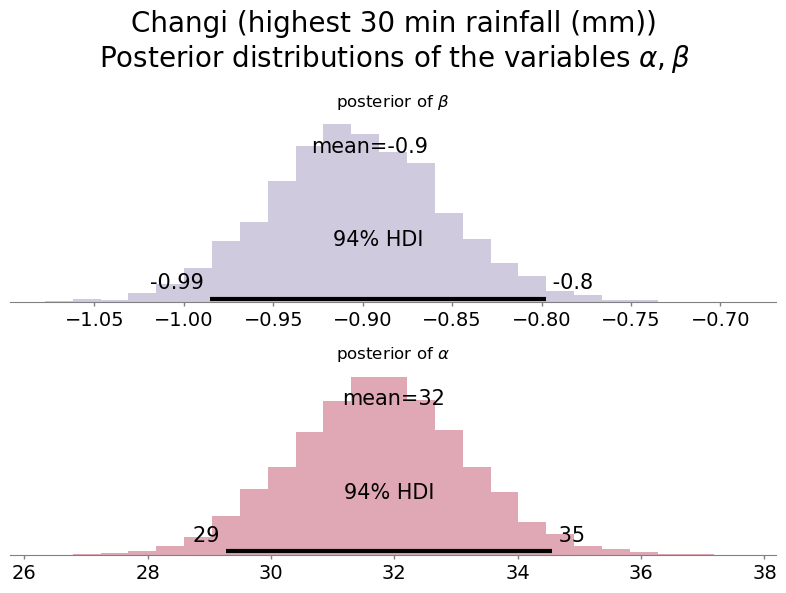

Changi (highest 60 min rainfall (mm)),55.36


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [beta]
>Metropolis: [alpha]


Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 86 seconds.


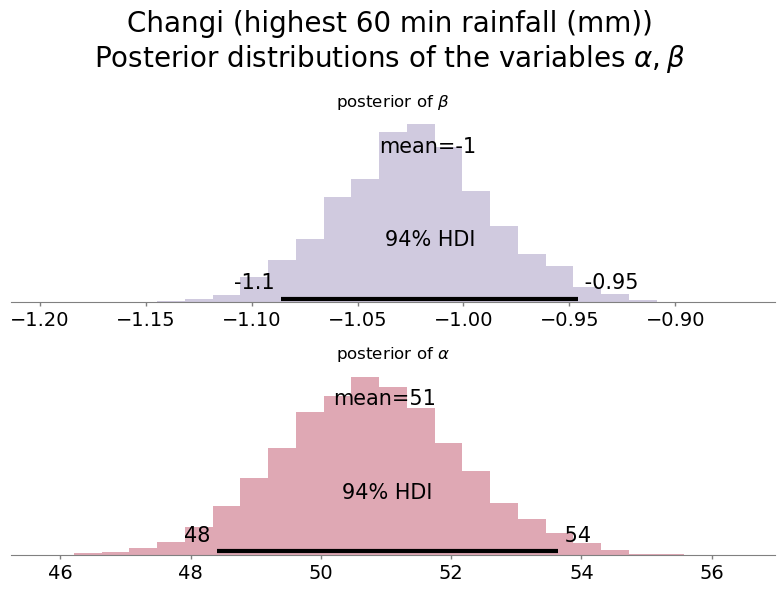

Changi (highest 120 min rainfall (mm)),67.72


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [beta]
>Metropolis: [alpha]


Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 84 seconds.


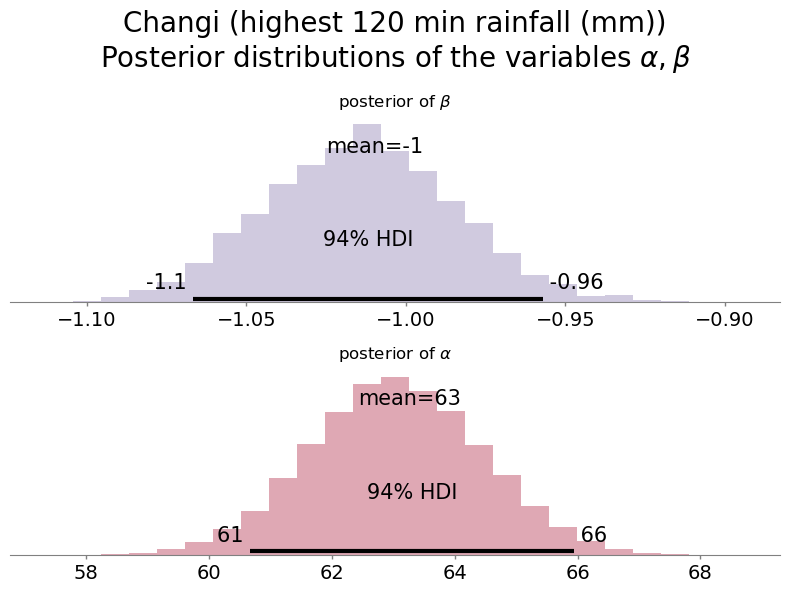

Geylang (daily rainfall total (mm)),85.02400000000002


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [beta]
>Metropolis: [alpha]


Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 87 seconds.


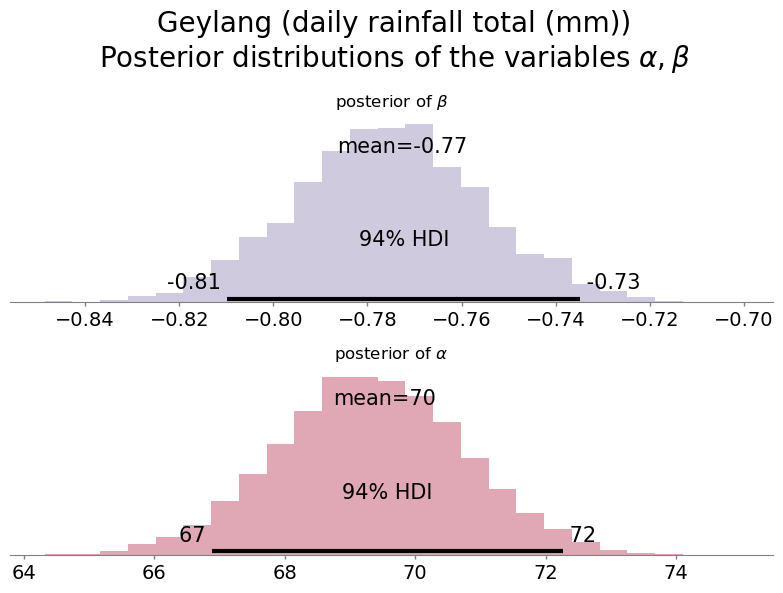

Geylang (highest 30 min rainfall (mm)),44.76


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [beta]
>Metropolis: [alpha]


Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 85 seconds.


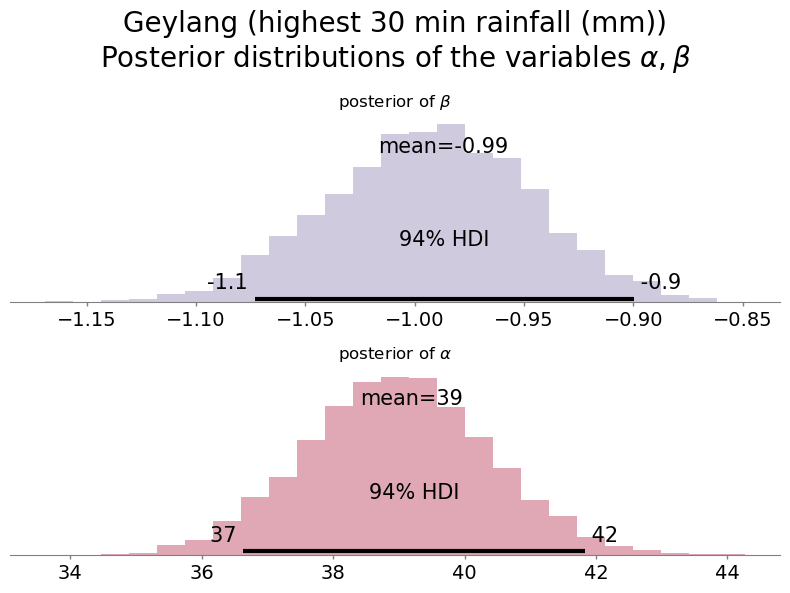

Geylang (highest 60 min rainfall (mm)),64.57600000000001


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [beta]
>Metropolis: [alpha]


Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 83 seconds.


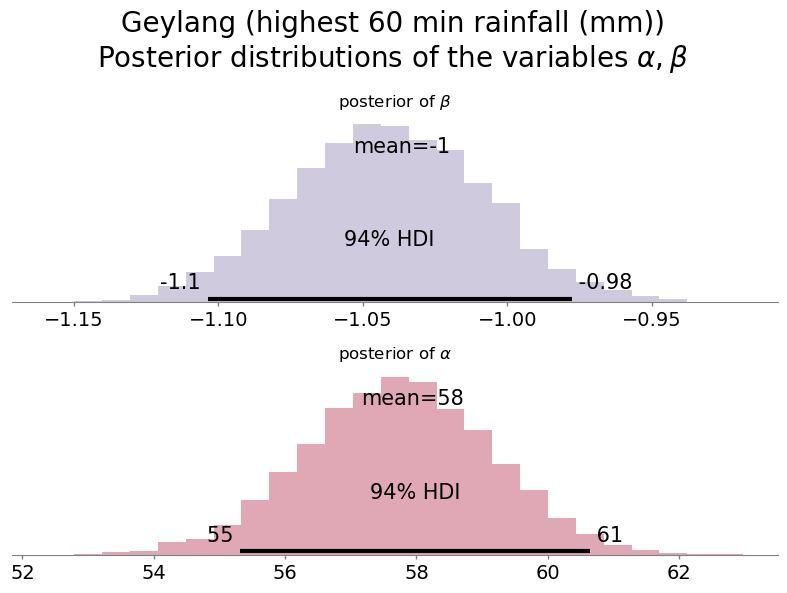

Geylang (highest 120 min rainfall (mm)),77.08800000000001


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [beta]
>Metropolis: [alpha]


Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 82 seconds.


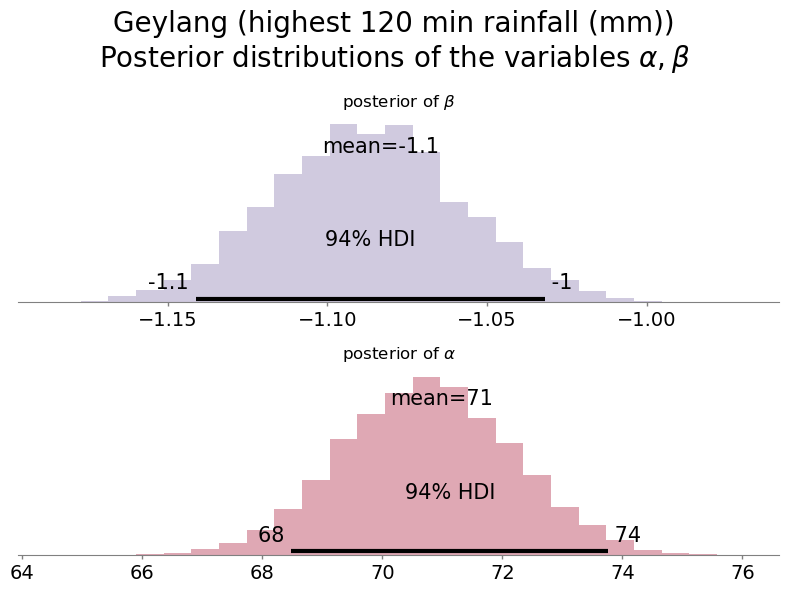

Jurong (daily rainfall total (mm)),78.51388888888887


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [beta]
>Metropolis: [alpha]


Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 82 seconds.


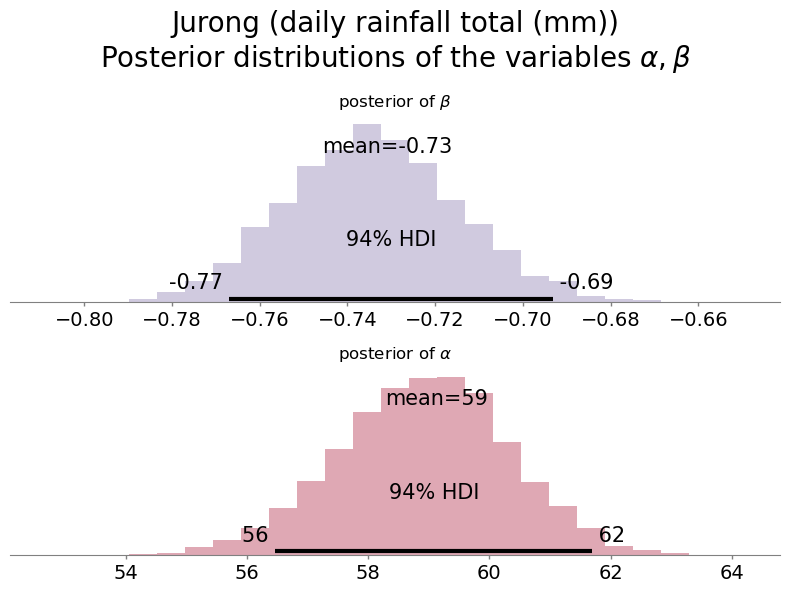

Jurong (highest 30 min rainfall (mm)),38.36944444444444


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [beta]
>Metropolis: [alpha]


Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 75 seconds.


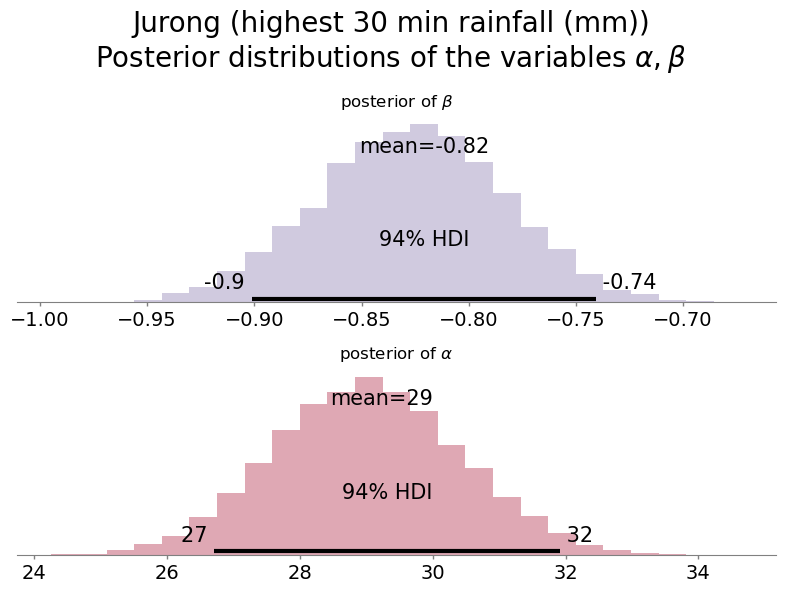

Jurong (highest 60 min rainfall (mm)),54.58888888888888


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [beta]
>Metropolis: [alpha]


Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 79 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details


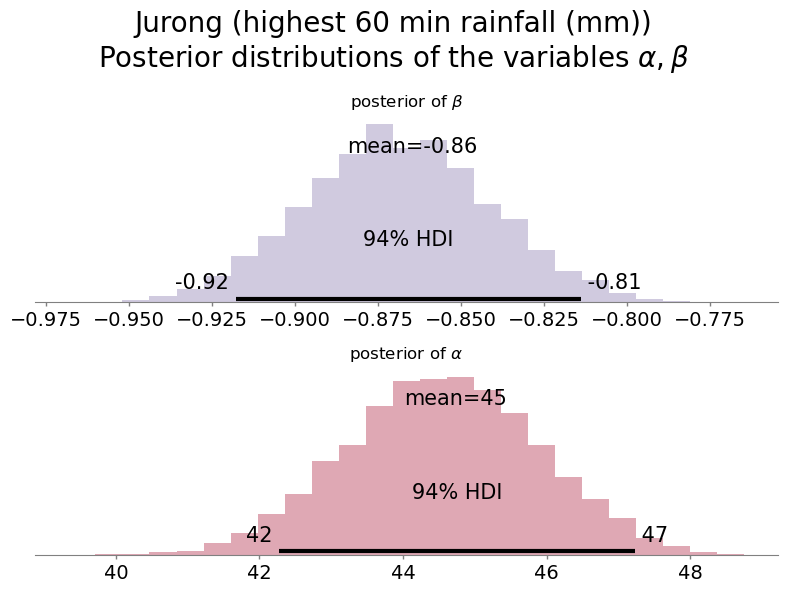

Jurong (highest 120 min rainfall (mm)),66.73888888888888


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [beta]
>Metropolis: [alpha]


Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 82 seconds.


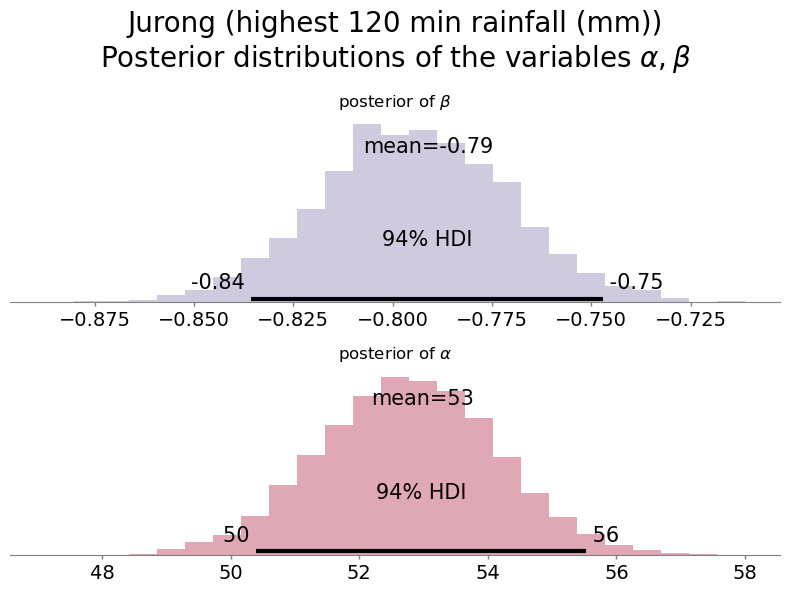

Kallang (daily rainfall total (mm)),71.36999999999999


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [beta]
>Metropolis: [alpha]


Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 81 seconds.


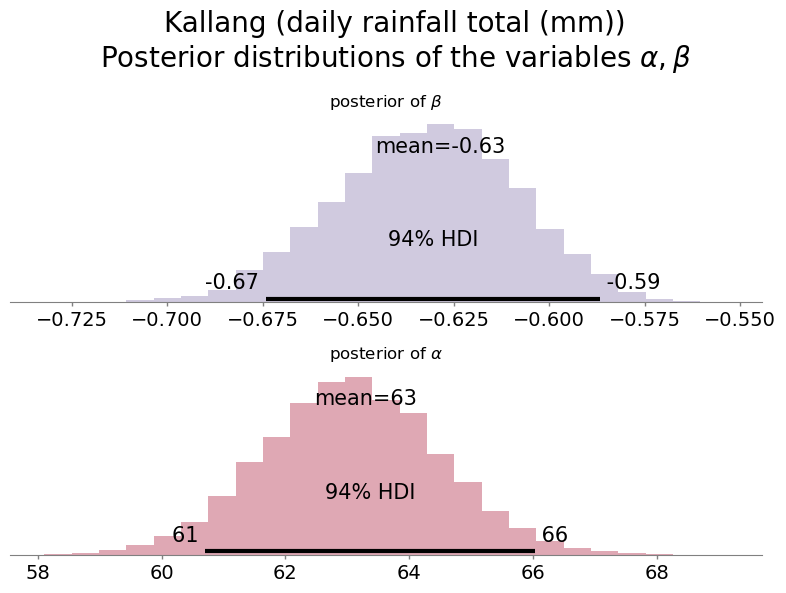

Kallang (highest 30 min rainfall (mm)),39.059999999999995


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [beta]
>Metropolis: [alpha]


Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 74 seconds.


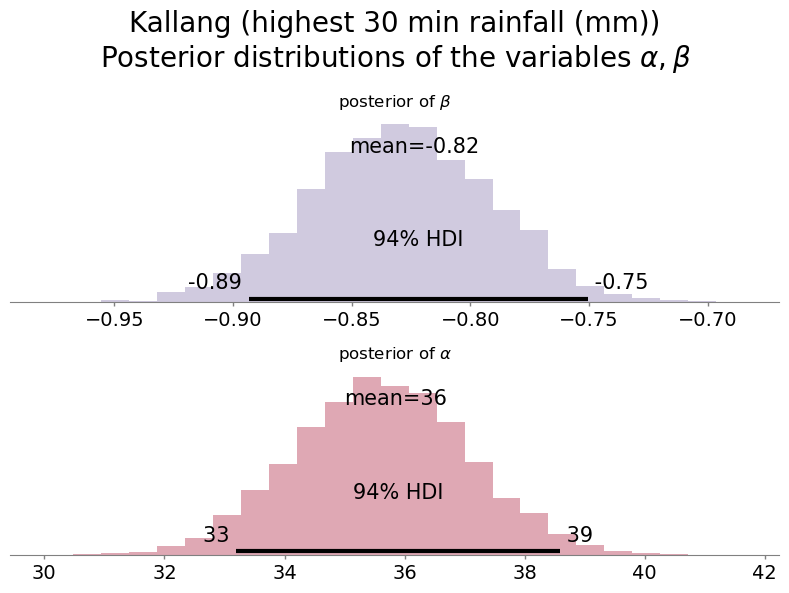

Kallang (highest 60 min rainfall (mm)),51.63000000000001


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [beta]
>Metropolis: [alpha]


Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 79 seconds.


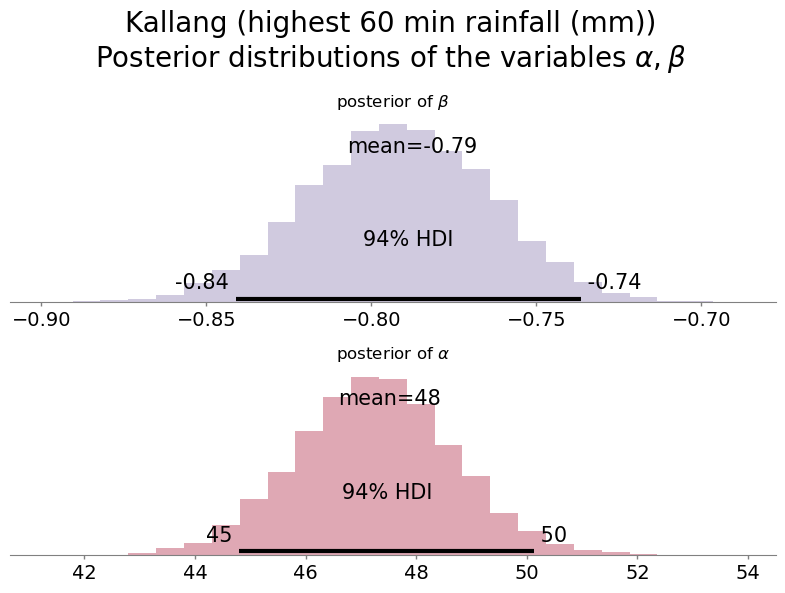

Kallang (highest 120 min rainfall (mm)),63.58


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [beta]
>Metropolis: [alpha]


Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 85 seconds.


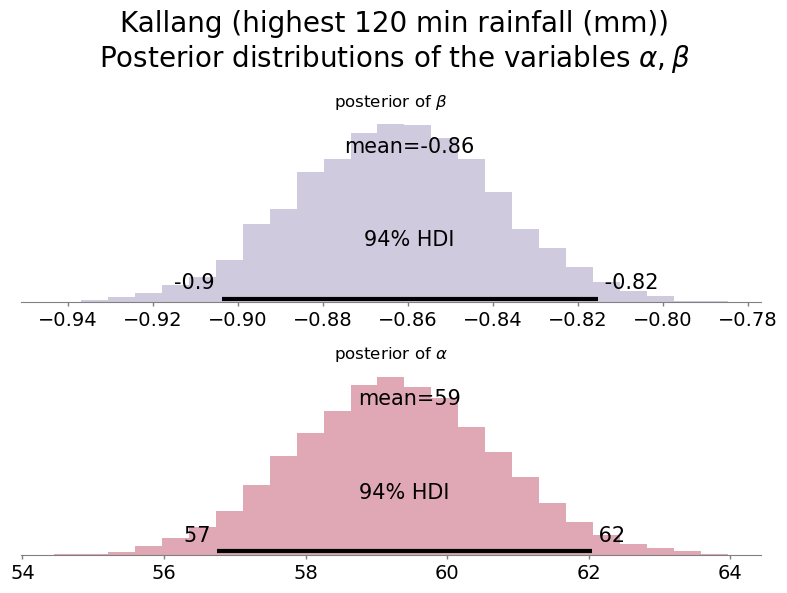

Kranji (daily rainfall total (mm)),63.47894736842106


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [beta]
>Metropolis: [alpha]


Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 81 seconds.


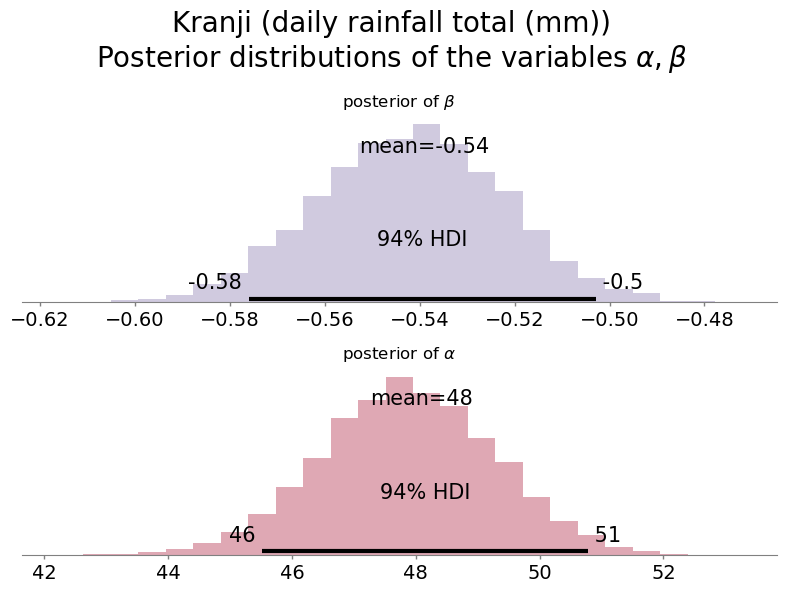

Kranji (highest 30 min rainfall (mm)),38.77894736842104


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [beta]
>Metropolis: [alpha]


Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 77 seconds.


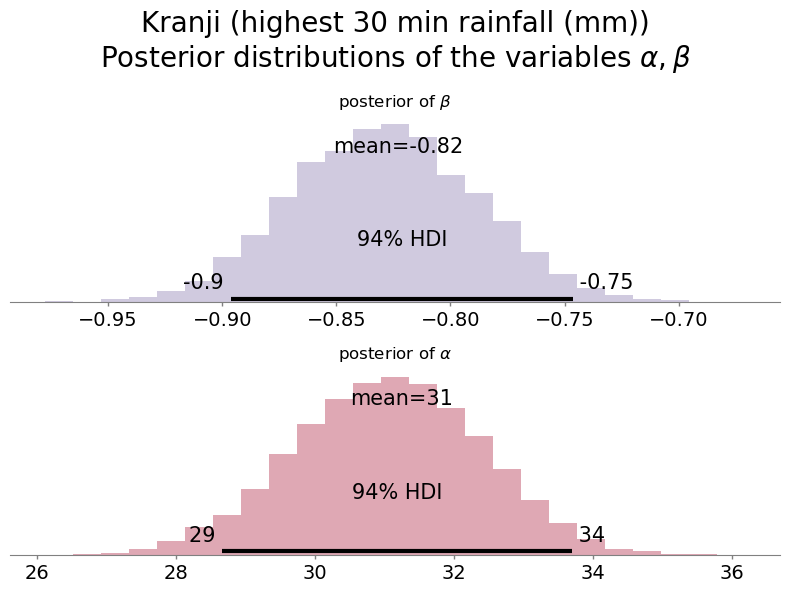

Kranji (highest 60 min rainfall (mm)),53.126315789473686


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [beta]
>Metropolis: [alpha]


Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 80 seconds.


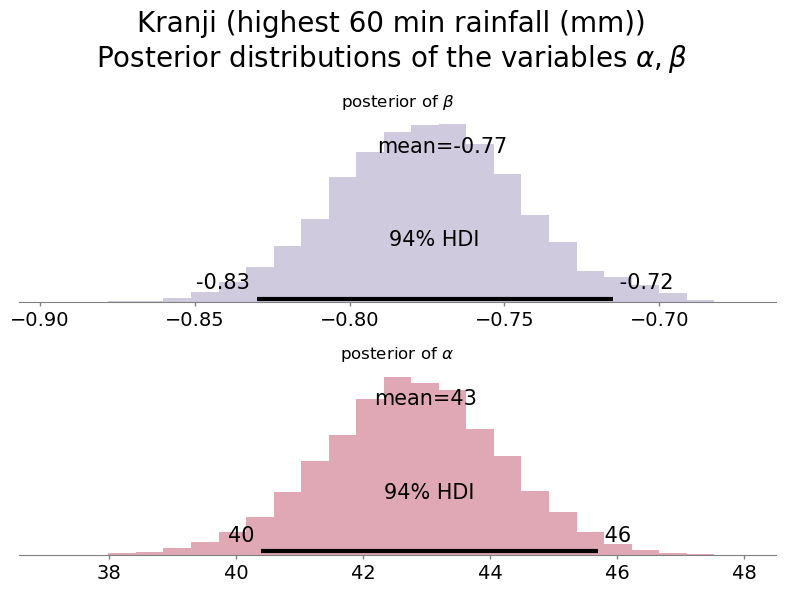

Kranji (highest 120 min rainfall (mm)),60.7421052631579


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [beta]
>Metropolis: [alpha]


Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 84 seconds.


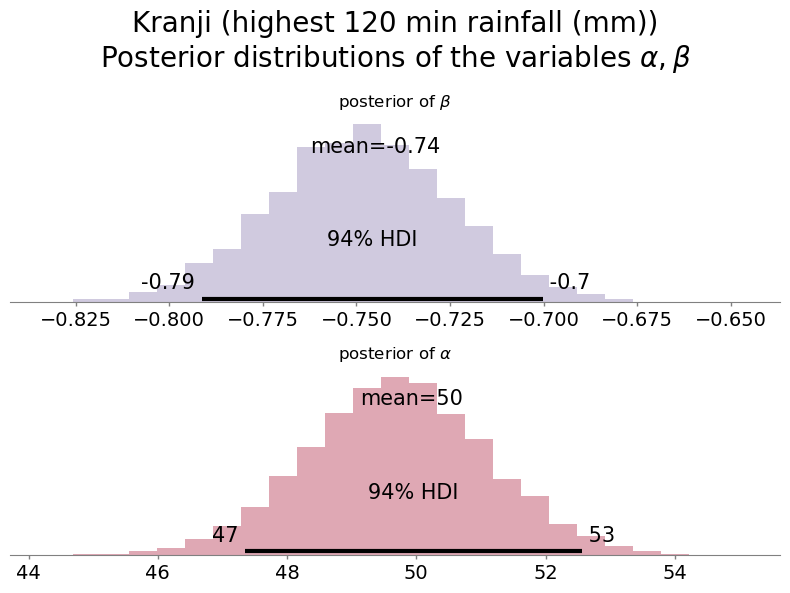

Pandan (daily rainfall total (mm)),78.11304347826086


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [beta]
>Metropolis: [alpha]


Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 85 seconds.


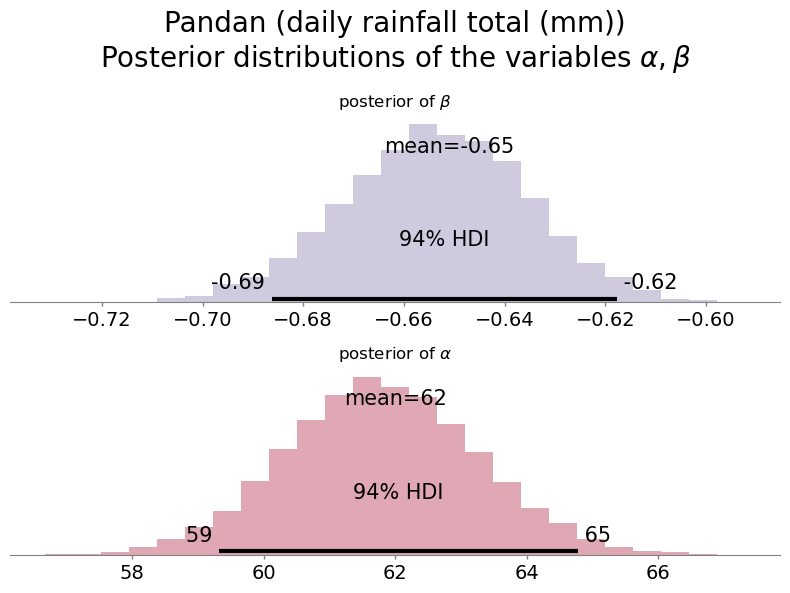

Pandan (highest 30 min rainfall (mm)),38.33043478260869


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [beta]
>Metropolis: [alpha]


Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 86 seconds.


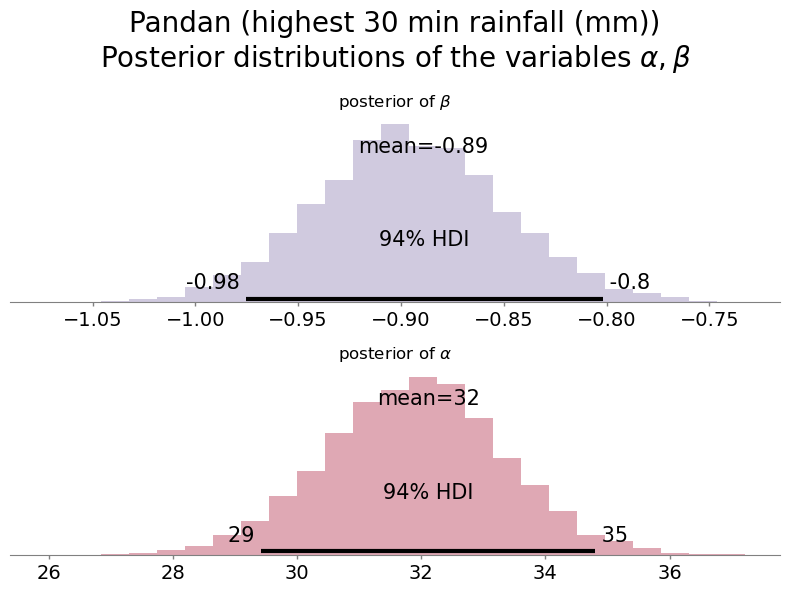

Pandan (highest 60 min rainfall (mm)),55.365217391304334


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [beta]
>Metropolis: [alpha]


Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 107 seconds.


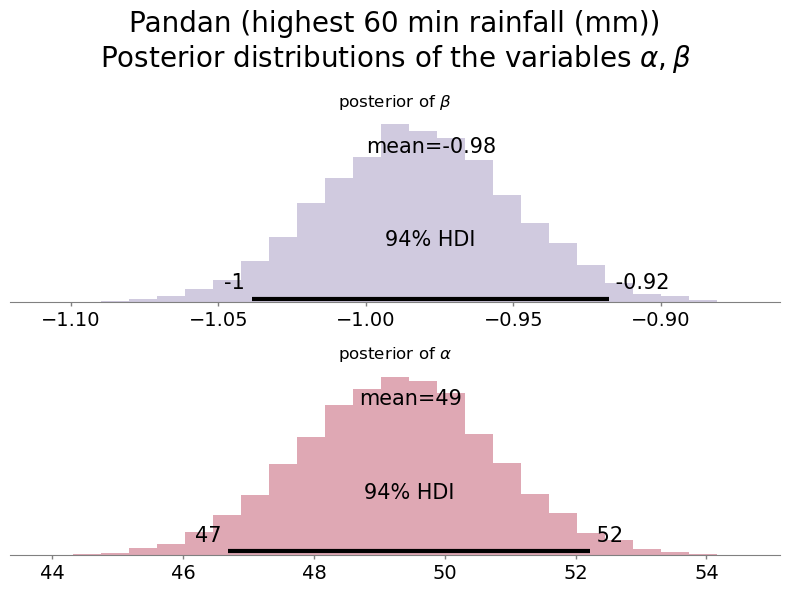

Pandan (highest 120 min rainfall (mm)),64.7913043478261


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [beta]
>Metropolis: [alpha]


Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 96 seconds.


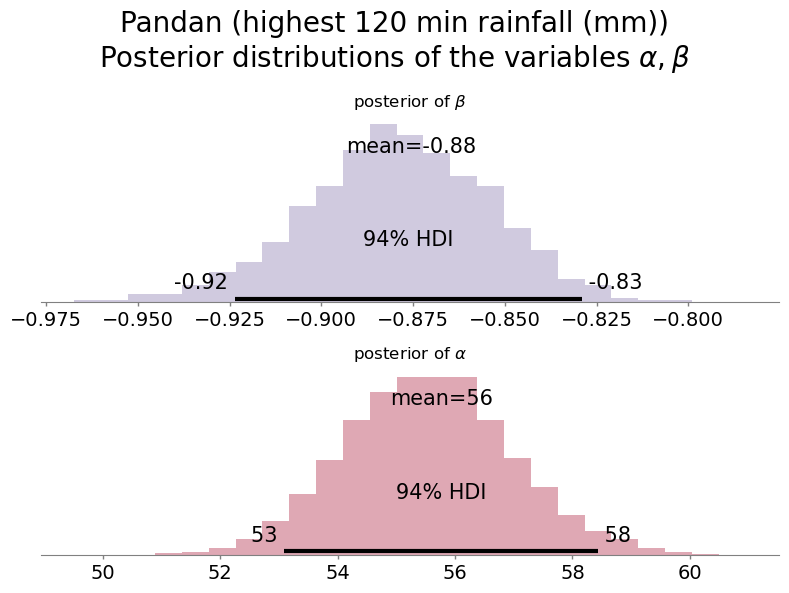

Punggol (daily rainfall total (mm)),76.87666666666668


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [beta]
>Metropolis: [alpha]


Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 96 seconds.


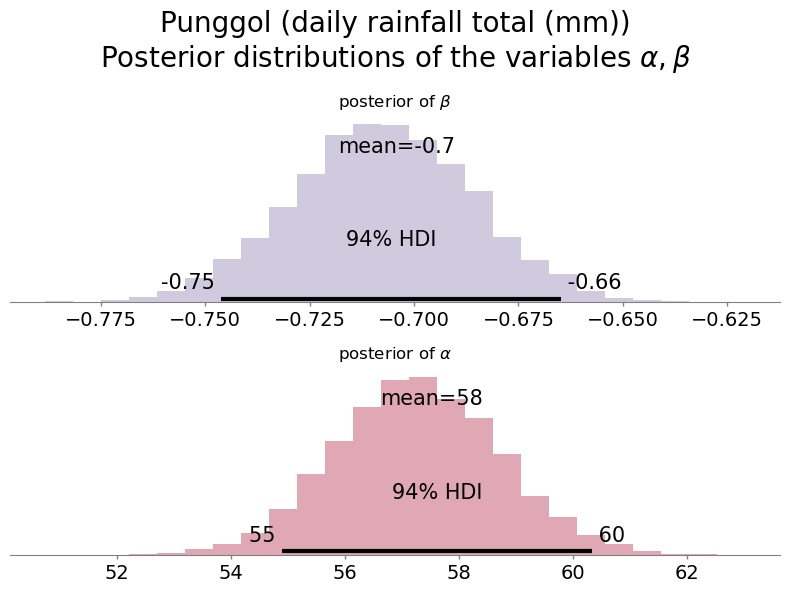

Punggol (highest 30 min rainfall (mm)),36.209090909090904


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [beta]
>Metropolis: [alpha]


Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 86 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details


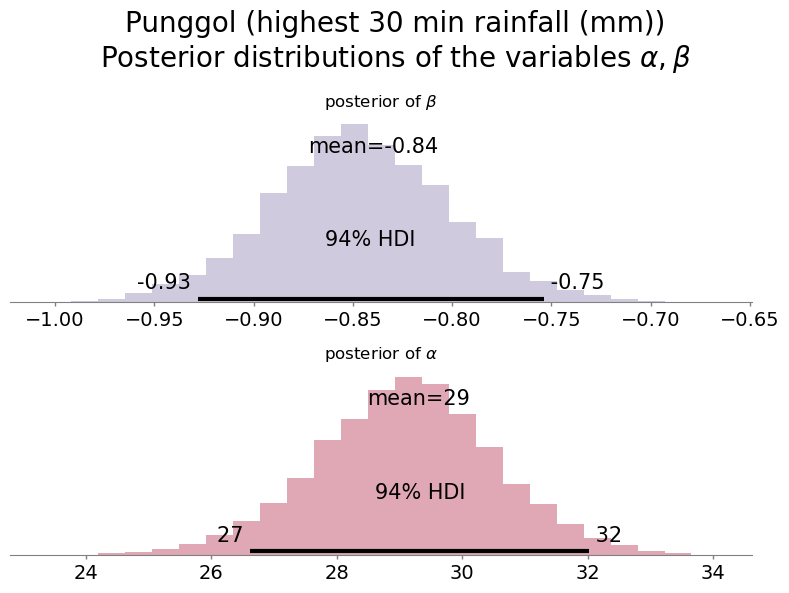

Punggol (highest 60 min rainfall (mm)),51.56363636363637


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [beta]
>Metropolis: [alpha]


Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 92 seconds.


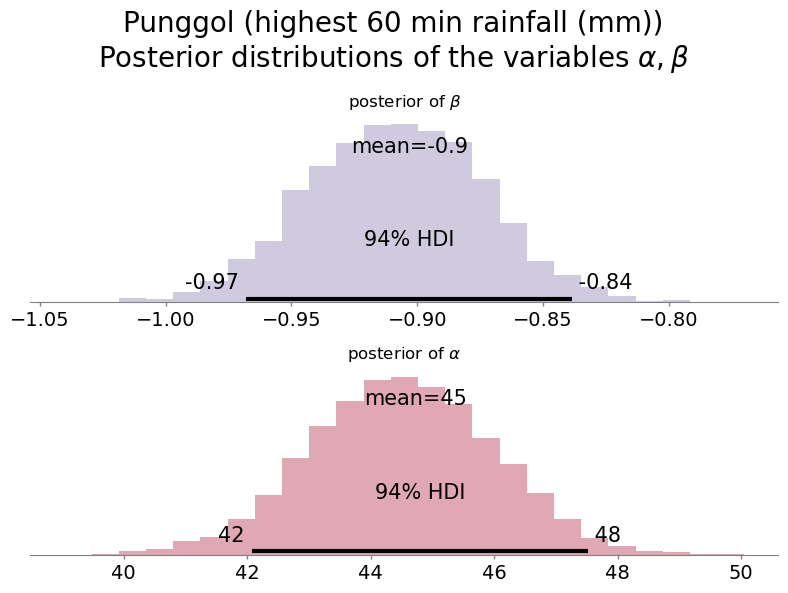

Punggol (highest 120 min rainfall (mm)),62.77272727272728


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [beta]
>Metropolis: [alpha]


Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 89 seconds.


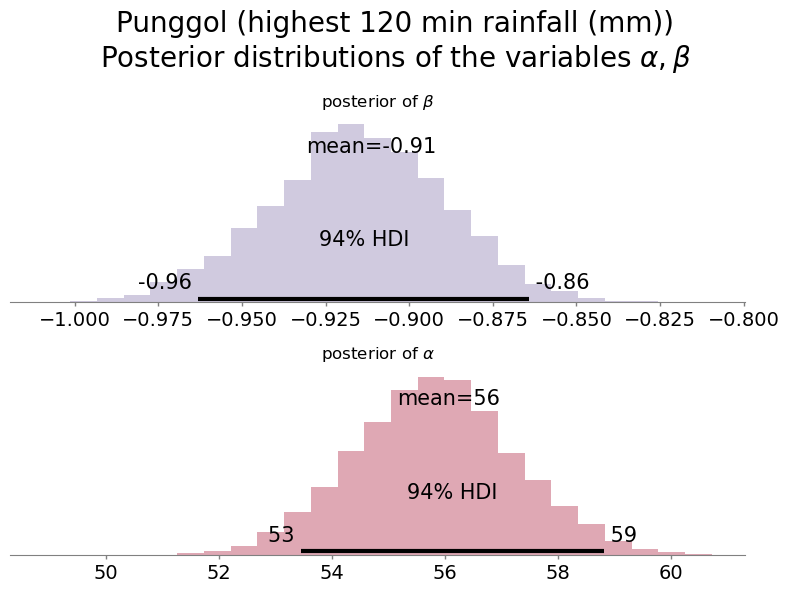

Singapore River (daily rainfall total (mm)),51.2


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [beta]
>Metropolis: [alpha]


Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 91 seconds.


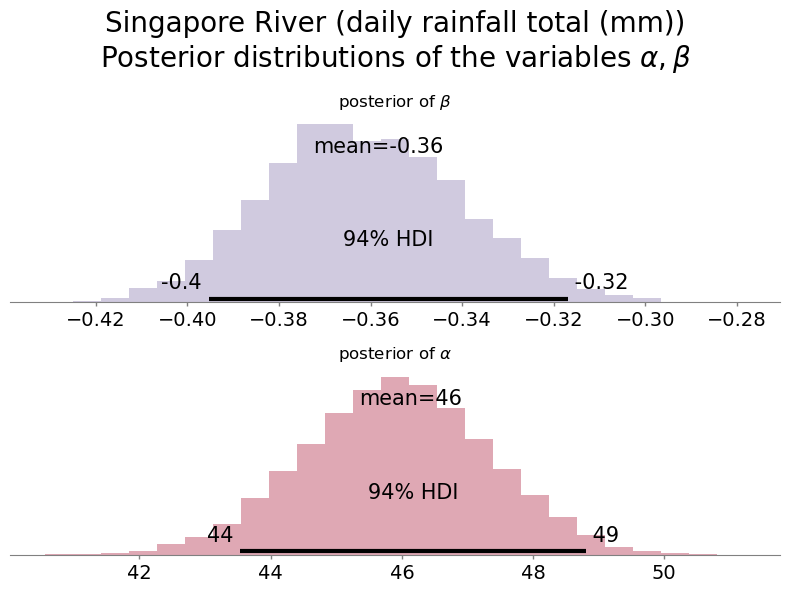

Singapore River (highest 30 min rainfall (mm)),29.1


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [beta]
>Metropolis: [alpha]


Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 85 seconds.


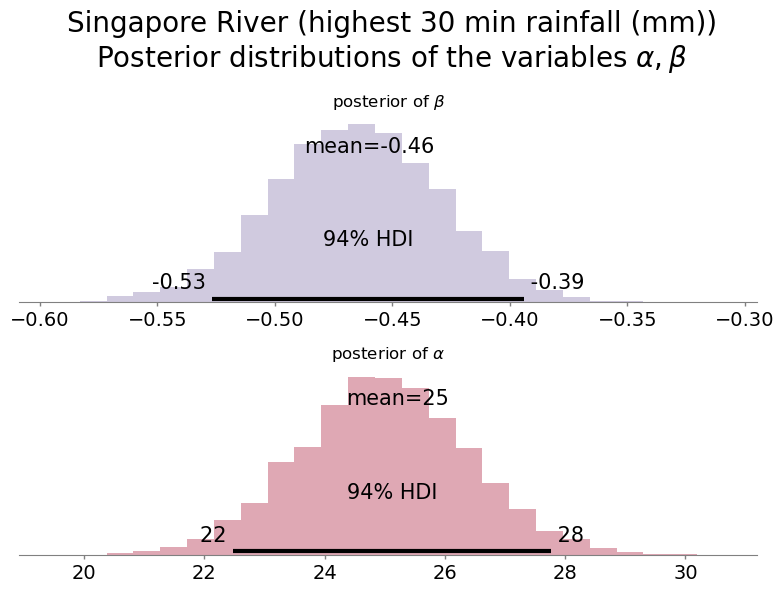

Singapore River (highest 60 min rainfall (mm)),35.45


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [beta]
>Metropolis: [alpha]


Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 86 seconds.


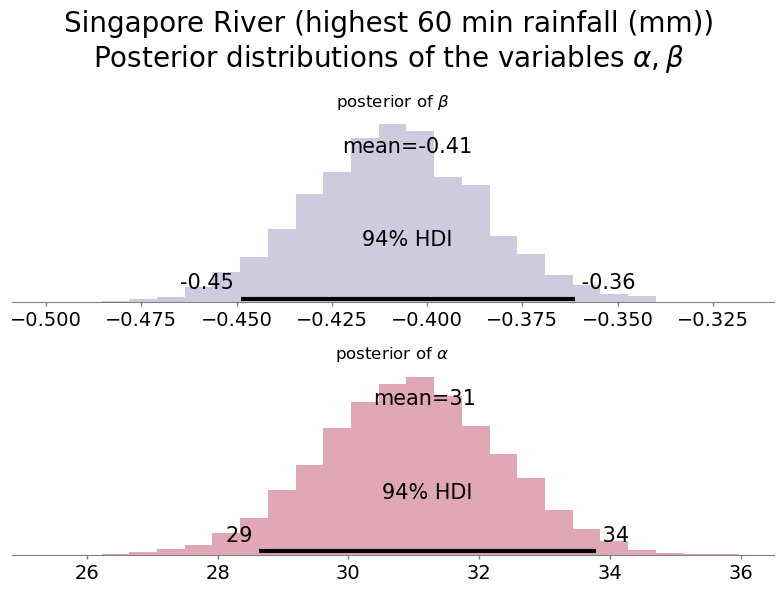

Singapore River (highest 120 min rainfall (mm)),40.35


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [beta]
>Metropolis: [alpha]


Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 84 seconds.


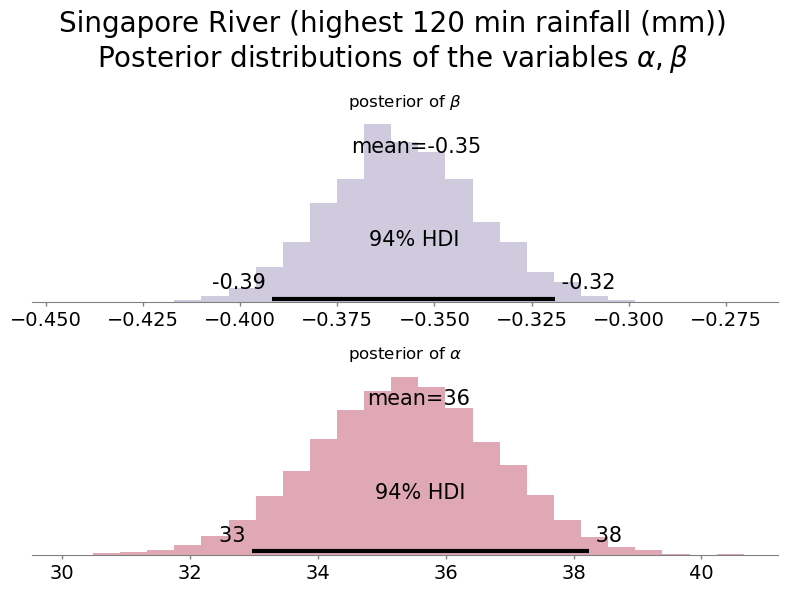

Stamford Marina (daily rainfall total (mm)),77.16470588235295


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [beta]
>Metropolis: [alpha]


Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 111 seconds.


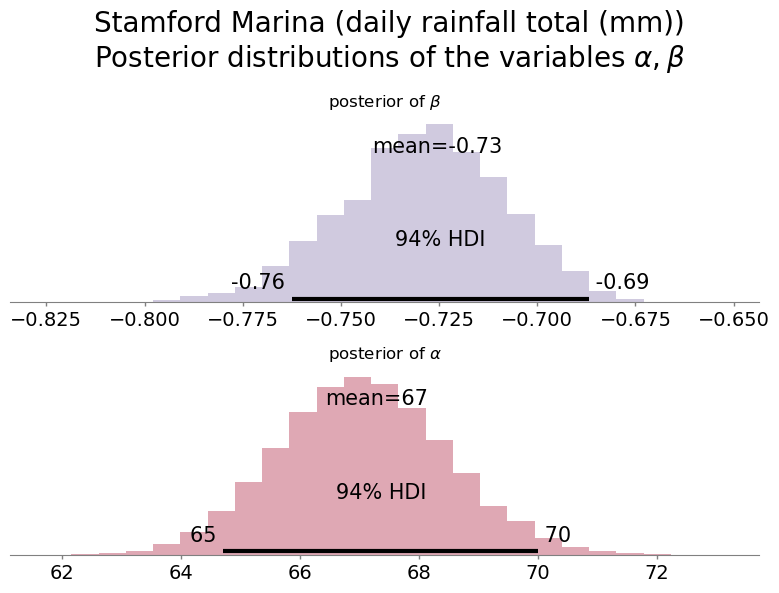

Stamford Marina (highest 30 min rainfall (mm)),40.04705882352942


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [beta]
>Metropolis: [alpha]


Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 95 seconds.


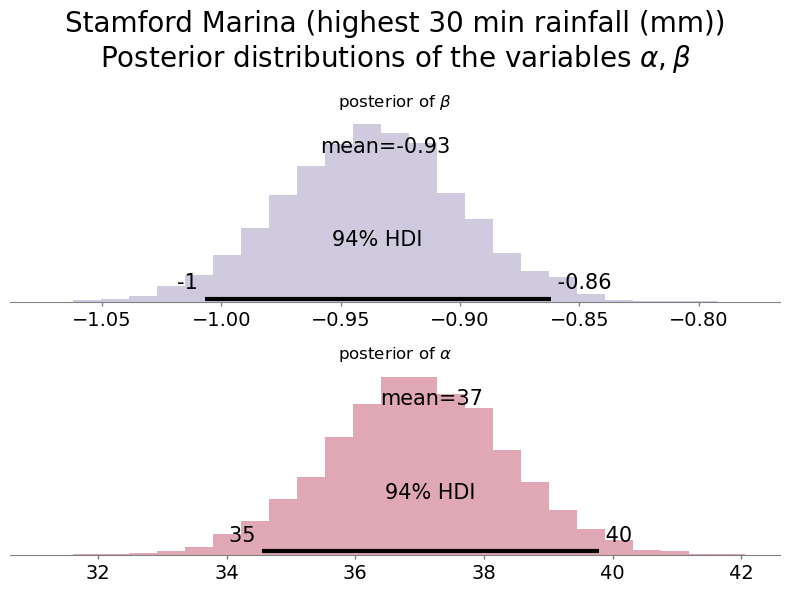

Stamford Marina (highest 60 min rainfall (mm)),60.4470588235294


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [beta]
>Metropolis: [alpha]


Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 106 seconds.


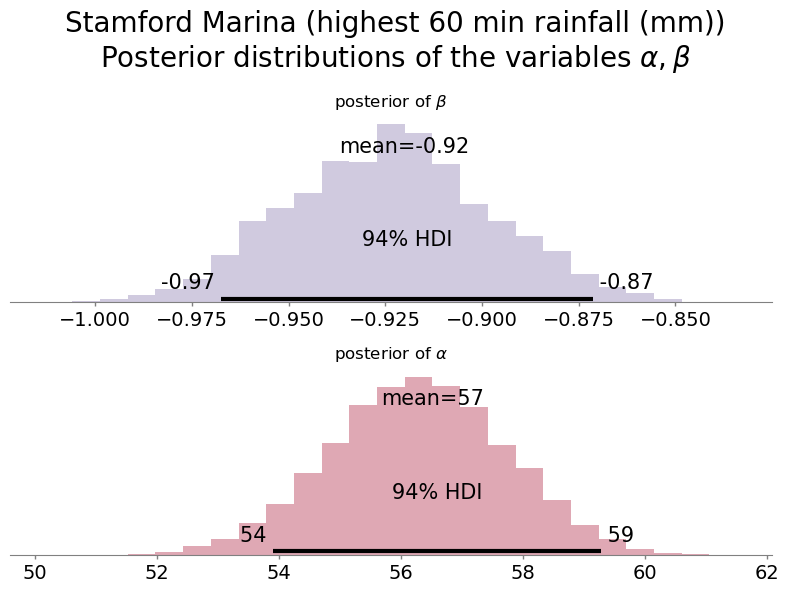

Stamford Marina (highest 120 min rainfall (mm)),68.81176470588235


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [beta]
>Metropolis: [alpha]


Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 121 seconds.


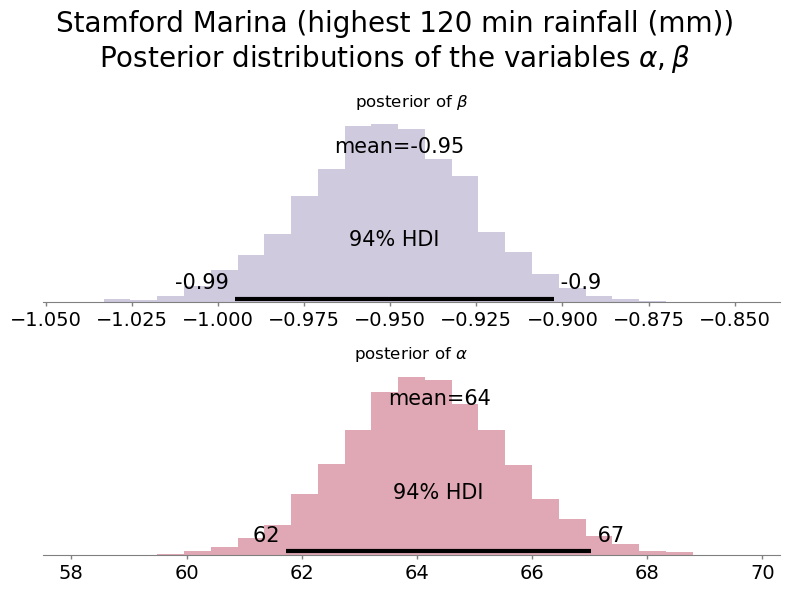

Woodlands (daily rainfall total (mm)),68.40769230769232


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [beta]
>Metropolis: [alpha]


Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 109 seconds.


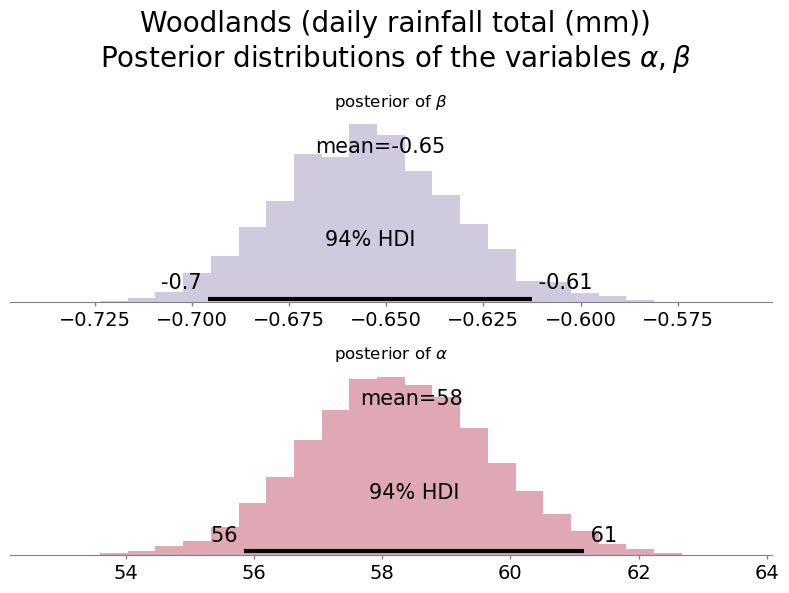

Woodlands (highest 30 min rainfall (mm)),42.63333333333333


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [beta]
>Metropolis: [alpha]


Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 101 seconds.


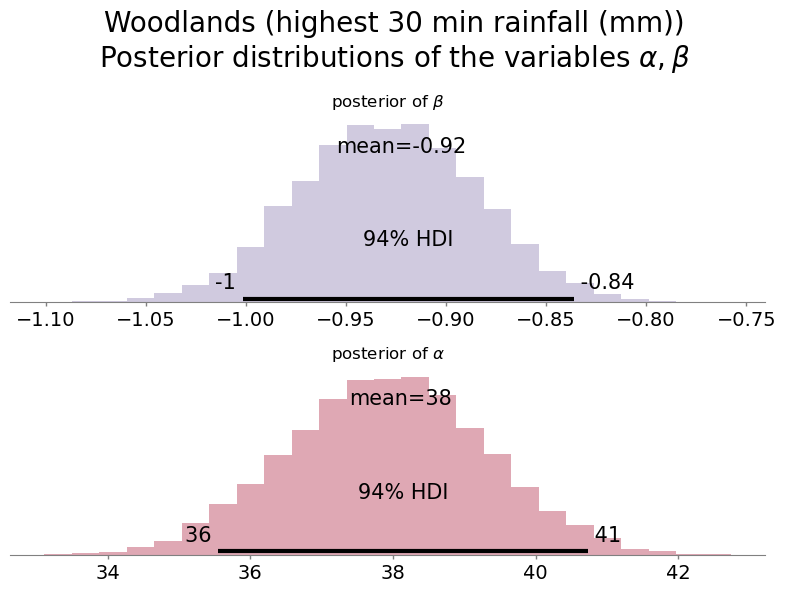

Woodlands (highest 60 min rainfall (mm)),58.625


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [beta]
>Metropolis: [alpha]


Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 102 seconds.


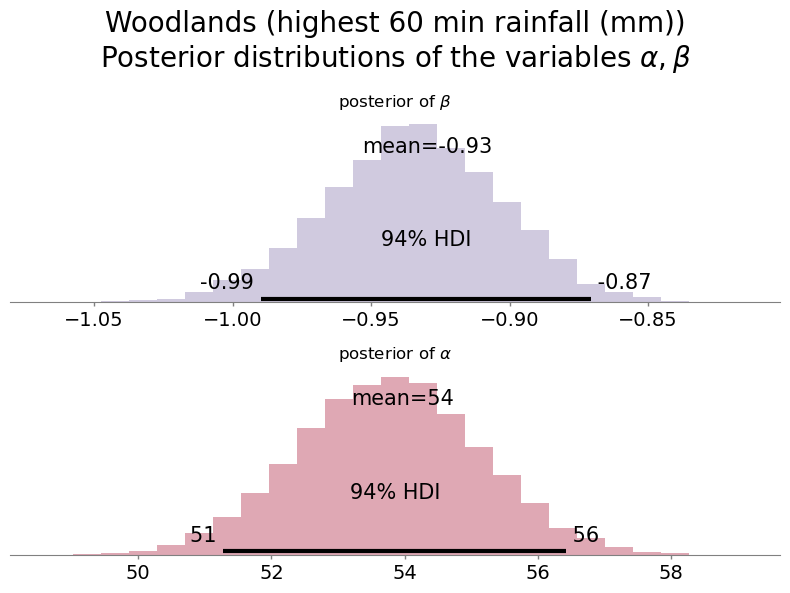

Woodlands (highest 120 min rainfall (mm)),67.23333333333333


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [beta]
>Metropolis: [alpha]


Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 97 seconds.


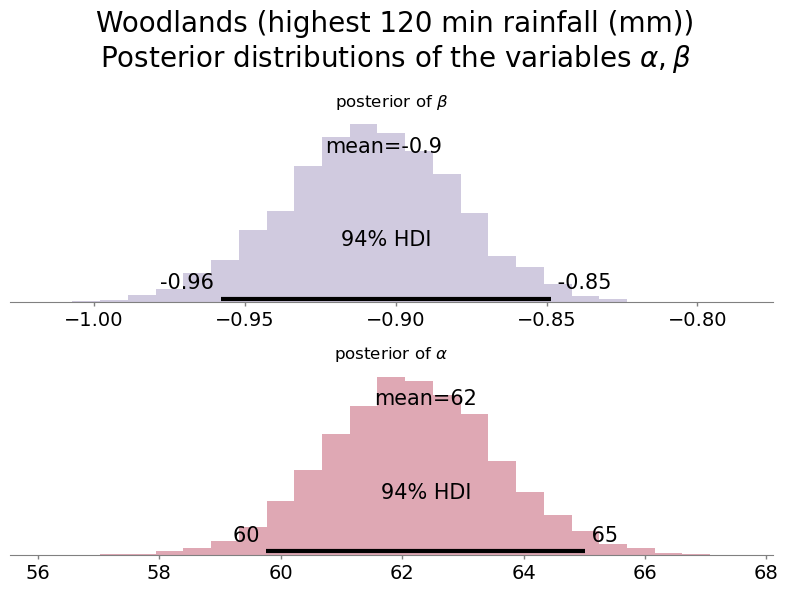

In [11]:
save_dir = "Flood_Weather_Data" # Exported_Data
for drainage_name, rf_dict in flood_occurrences_dict.items():
    for rf_type, rf in rf_dict.items():
        y,x = rf # flood occurrence vs ppt
        # use mean as the prior
        prior_mu = np.mean(x[y>0])
        print(f'{drainage_name} ({rf_type}),{prior_mu}')
        # fit bayesian model
        trace = BayesFlood.bayesian_flood_model(x,y,
                                    beta_mu=0,beta_tau=0.5,beta_initval=0,
                                    alpha_mu=prior_mu,alpha_tau=0.5,alpha_initval=prior_mu,
                                    n_sampling=10000)
        alpha_samples, beta_samples,p_t = BayesFlood.sample_posterior(x,trace)
        utils.pickle_data(p_t,save_fp=os.path.join(os.getcwd(),save_dir,f'ExpectedProb_{drainage_name} ({rf_type})'))
        utils.pickle_data(alpha_samples,save_fp=os.path.join(os.getcwd(),save_dir,f'alpha_{drainage_name} ({rf_type})'))
        utils.pickle_data(beta_samples,save_fp=os.path.join(os.getcwd(),save_dir,f'beta_{drainage_name} ({rf_type})'))
        BayesFlood.plot_posterior_arviz(trace,f'{drainage_name} ({rf_type})',
                             save_fp=os.path.join(os.getcwd(),save_dir,f'{drainage_name} ({rf_type})'))

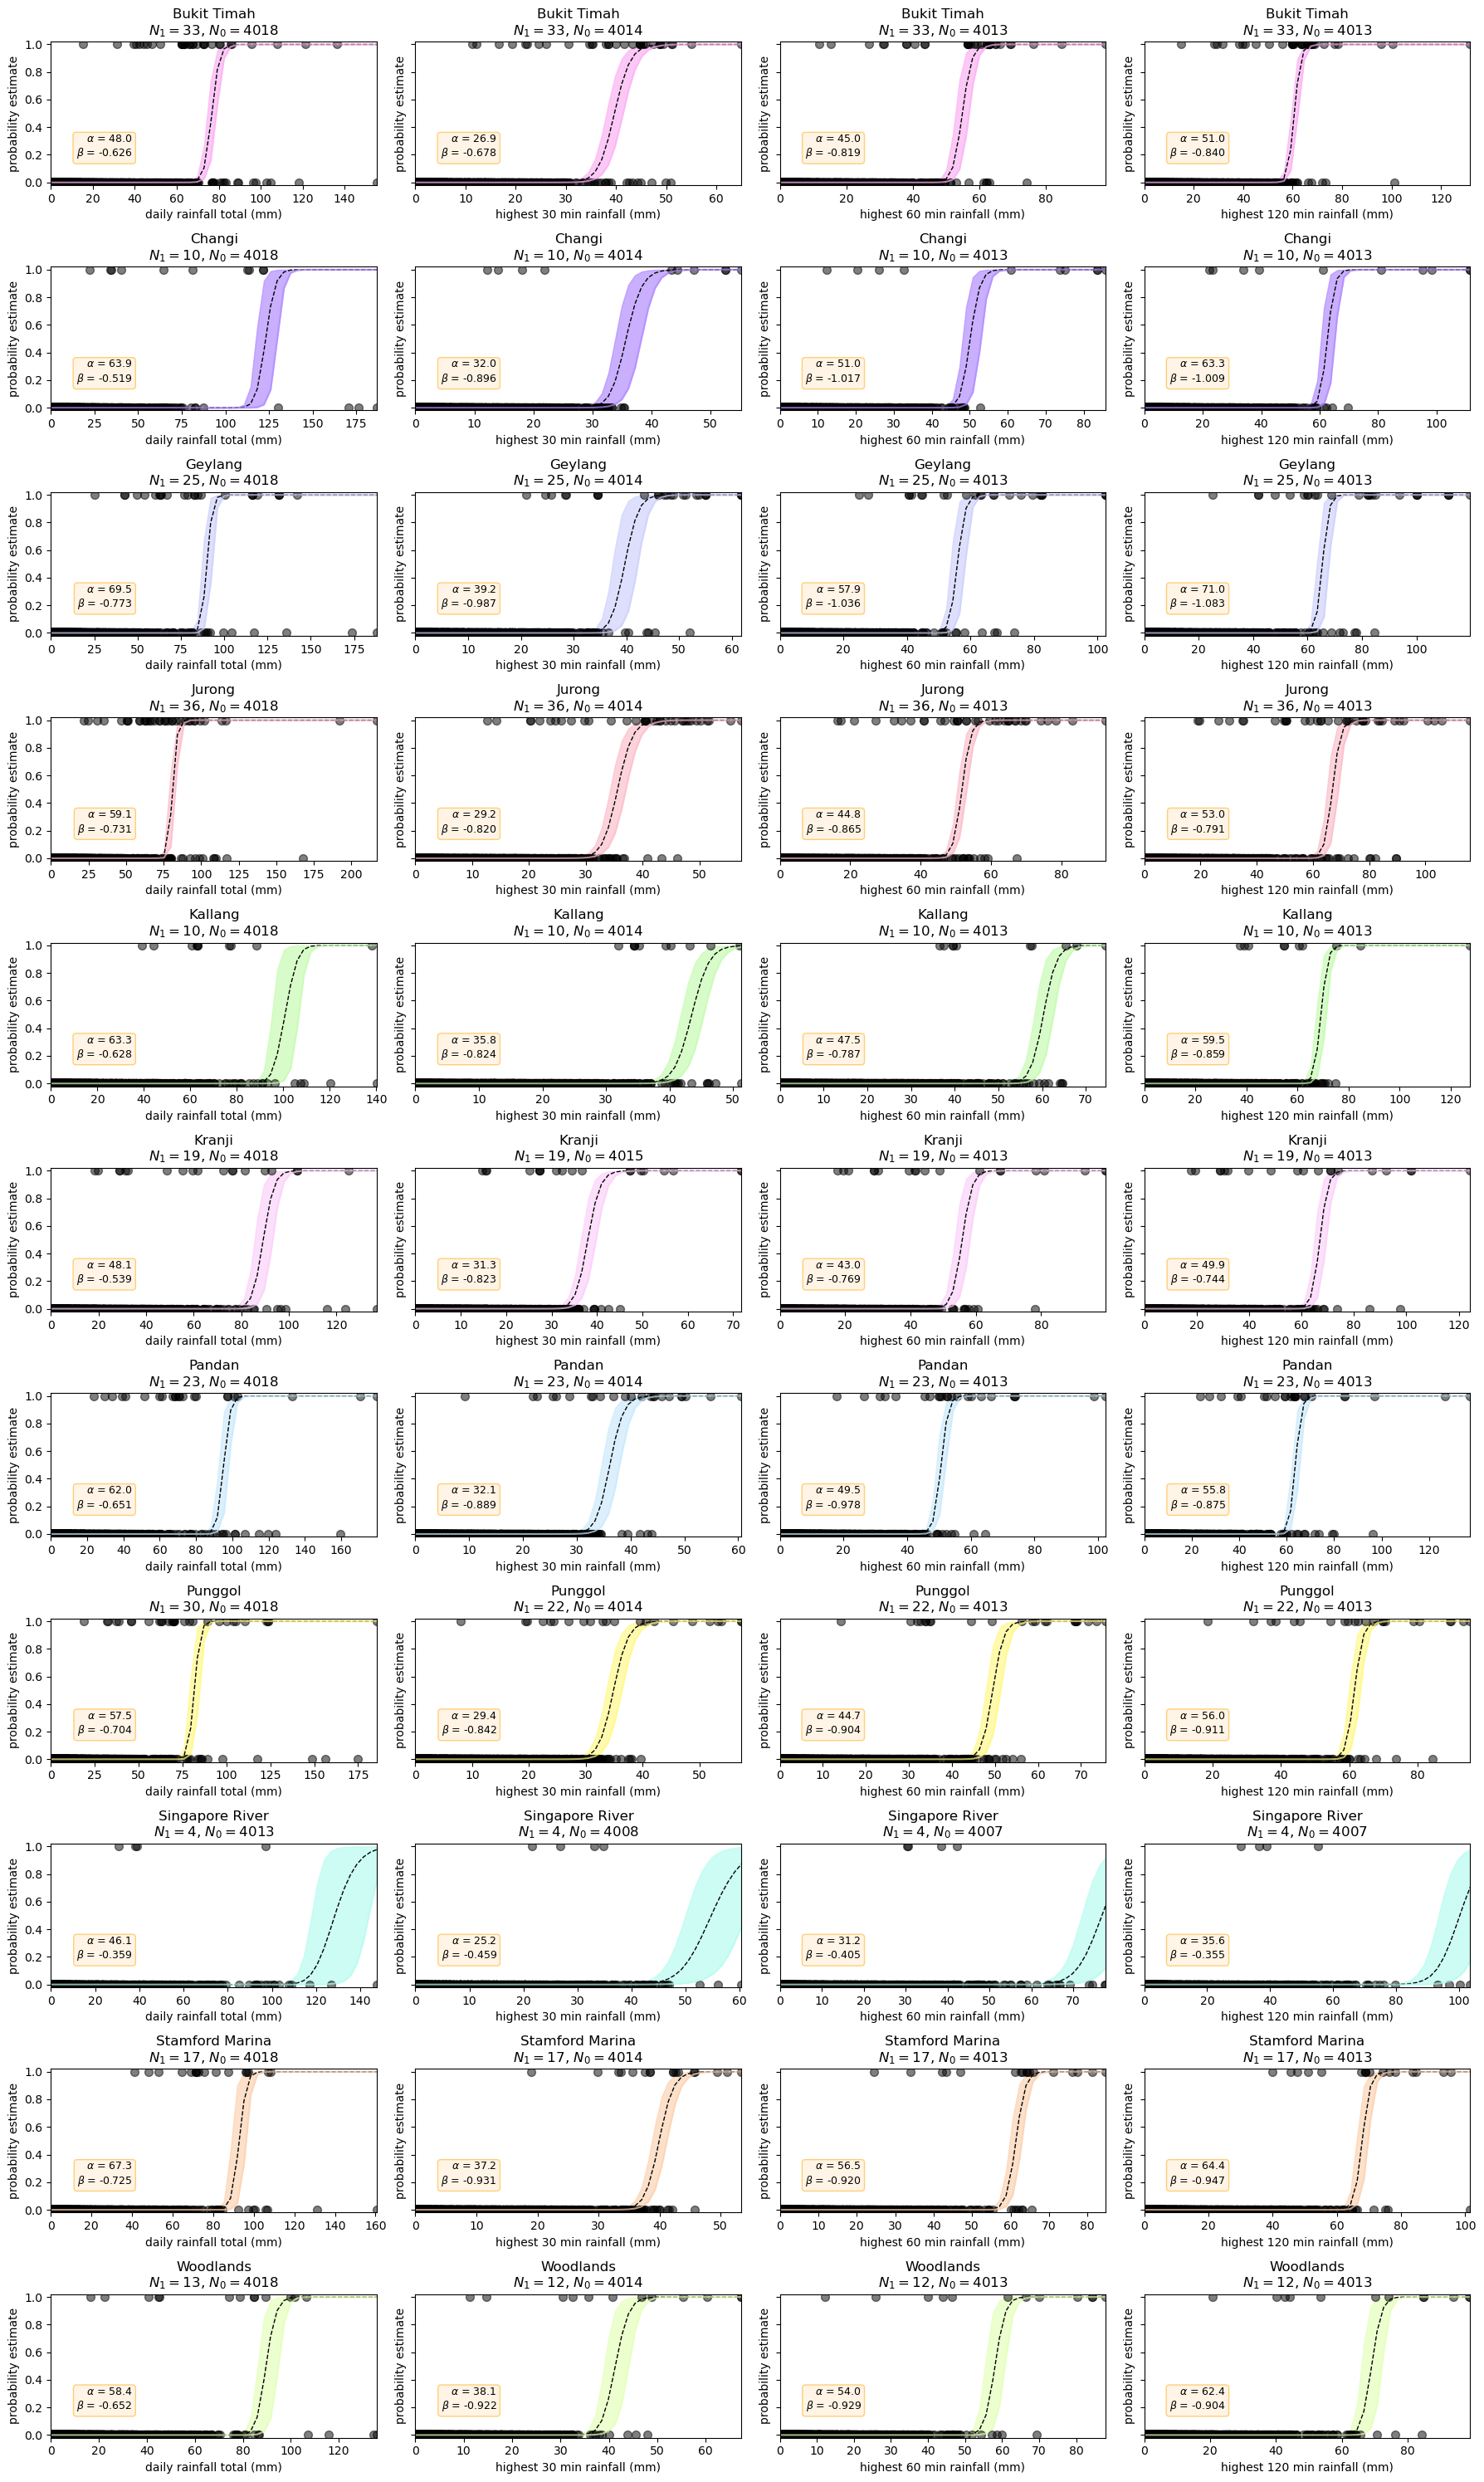

In [13]:
def plot_posterior_dist_grid(imported_dir,save_dir=None):
    """ 
    Args:
        imported_dir (str): directory to import the pkl files
        save_dir (str): directory to save data in
    """
    # save_dir = r"Exported_Data"
    # sampled_posterior_fps = [os.path.join(save_dir,fp) for fp in os.listdir(save_dir) if fp.endswith('pkl')]
    colormap = {'Changi':'#b28efe','Punggol':'#fff98b','Woodlands':'#e5ffba','Kallang':'#c7fcb3',
                'Bukit Timah':'#fcb3f4','Stamford Marina':'#fcd3b3','Singapore River':'#b8fcf0',
                'Kranji':'#fcd2fa','Pandan':'#ccebfc','Jurong':'#fcc0cd','Geylang':'#cfd2fc'}
    
    fig, axes = plt.subplots(11,4,figsize=(18,30),sharey=True)
    for row_idx, (drainage_name, rf_dict) in enumerate(flood_occurrences_dict.items()):
        for col_idx, (rf_type, rf) in enumerate(rf_dict.items()):
            y,x = rf # flood occurrence vs ppt
            p_t_fp = os.path.join(os.getcwd(),imported_dir,f'ExpectedProb_{drainage_name} ({rf_type}).pkl')
            alpha_fp = os.path.join(os.getcwd(),imported_dir,f'alpha_{drainage_name} ({rf_type}).pkl')
            beta_fp = os.path.join(os.getcwd(),imported_dir,f'beta_{drainage_name} ({rf_type}).pkl')
            sampled_posterior = utils.load_pickle(p_t_fp)
            alpha = utils.load_pickle(alpha_fp)
            beta = utils.load_pickle(beta_fp)
            ax = axes[row_idx,col_idx]
            BayesFlood.plot_fitted_logistic(x,y,sampled_posterior,title=f'{drainage_name} ({rf_type}).pkl',
                                 ax=ax,color = colormap[drainage_name])
            # find number of flood vs non-flood events
            n_flood = y[y>0].shape[0]
            n_non_flood = y.shape[0] - n_flood
            # plot parameters
            bbox = dict(boxstyle='round', fc='blanchedalmond', ec='orange', alpha=0.5)
            stats = (f'$\\alpha$ = {np.median(alpha):.1f}\n'
             f'$\\beta$ = {np.median(beta):.3f}')
            ax.text(0.25, 0.2, stats, fontsize=9, bbox=bbox,transform=ax.transAxes, horizontalalignment='right')
    
            ax.set_title(f'{drainage_name}\n'+r"$N_1={n_flood}$, $N_0={n_non_flood}$".format(n_flood=n_flood,n_non_flood=n_non_flood))
            ax.set_xlabel(rf_type)

    plt.tight_layout()
    if save_dir is not None and os.path.exists(save_dir):
        plt.savefig(os.path.join(save_dir,f'expected_probability_drainageCatchments.png'), bbox_inches = 'tight')
    plt.show()

save_dir = os.path.join(os.getcwd(),"Flood_Weather_Data")
plot_posterior_dist_grid(imported_dir="Flood_Weather_Data",save_dir=save_dir)

## Assess goodness of fit for models
- Calculate accuracy
- class weighted accuracy
- Recall
- Precision
- F1 score
- AUC-ROC
- Precision-Recall AUC

In [14]:
def get_accuracy_metrics(imported_dir,threshold = 0.5,save_dir=None):
    """ outputs a csv file across drainage basins and type of rainfall
    Args:
        imported_dir (str): directory to import the pkl files
        threshold (float): threshold above the probability which will classify observation as positive (i.e. flooded)
        save_dir (str): filepath of where to store the csv
    Returns:
        pd.DataFrame: dataframe of the accuracy metrics for each drainage basins and rainfall type
    """
    df_dict = []
    for drainage_name, rf_dict in flood_occurrences_dict.items():
        for rf_type, rf in rf_dict.items():
            y_true,x = rf # flood occurrence vs ppt
            alpha_fp = os.path.join(os.getcwd(),imported_dir,f'alpha_{drainage_name} ({rf_type}).pkl')
            beta_fp = os.path.join(os.getcwd(),imported_dir,f'beta_{drainage_name} ({rf_type}).pkl')
            alpha = utils.load_pickle(alpha_fp)
            beta = utils.load_pickle(beta_fp)
            beta_mean, alpha_mean = beta.mean(), alpha.mean()
            y_probs = utils.logistic(x, beta_mean, alpha_mean) # outputs probabilities between 0 and 1
            y_pred = y_probs > threshold
            y_pred = y_pred.astype(int) # convert boolean to binary
            # metrics
            assert y_pred.shape[0] == y_true.shape[0], f"both vectors have different length: y_pred: {y_pred.shape}, y_true: {y_true.shape}"
            accuracy = flood_metrics.accuracy(y_true,y_pred)
            precision = flood_metrics.precision(y_true,y_pred)
            recall = flood_metrics.recall(y_true,y_pred)
            f1_score = flood_metrics.f1_score(y_true,y_pred)
            auc_roc = flood_metrics.auc_roc(y_true,y_probs)
            log_loss = flood_metrics.log_loss(y_true,y_probs)

            # find number of flood vs non-flood events
            n_flood = int(y_true[y_true>0].shape[0])
            n_non_flood = int(y_true.shape[0] - n_flood)
            df_dict.append({'drainage_name':drainage_name,'rainfall_type':rf_type,
                            'accuracy':accuracy,'precision':precision,'recall':recall,
                            'f1_score':f1_score, 'auc_roc':auc_roc, 'log_loss':log_loss,
                            'n_flood': n_flood, 'n_non_flood': n_non_flood})
            
    
    df = pd.DataFrame(df_dict)
            
    if save_dir is not None and os.path.exists(save_dir):
        df.to_csv(os.path.join(save_dir,"logistic_curve_goodness_of_fit.csv"),index=False)
    return df

save_dir = os.path.join(os.getcwd(),"Flood_Weather_Data")
df = get_accuracy_metrics(imported_dir="Flood_Weather_Data",save_dir=save_dir)
df

,drainage_name,rainfall_type,accuracy,precision,recall,f1_score,auc_roc,log_loss,n_flood,n_non_flood
0,Bukit Timah,daily rainfall total (mm),0.989879,0.346154,0.272727,0.305085,0.984848,0.112206,33,4018
1,Bukit Timah,highest 30 min rainfall (mm),0.994317,0.692308,0.545455,0.610169,0.984471,0.040902,33,4014
2,Bukit Timah,highest 60 min rainfall (mm),0.996045,0.793103,0.696970,0.741935,0.987473,0.056804,33,4013
3,Bukit Timah,highest 120 min rainfall (mm),0.994315,0.692308,0.545455,0.610169,0.988734,0.065802,33,4013
4,Changi,daily rainfall total (mm),0.996524,0.000000,0.000000,0.000000,0.982728,0.072579,10,4018
5,Changi,highest 30 min rainfall (mm),0.999006,1.000000,0.600000,0.750000,0.979621,0.017572,10,4014
6,Changi,highest 60 min rainfall (mm),0.998757,0.857143,0.600000,0.705882,0.979741,0.027487,10,4013
7,Changi,highest 120 min rainfall (mm),0.998260,0.714286,0.500000,0.588235,0.985821,0.033072,10,4013
8,Geylang,daily rainfall total (mm),0.994064,0.529412,0.360000,0.428571,0.991747,0.111305,25,4018
9,Geylang,highest 30 min rainfall (mm),0.996534,0.739130,0.680000,0.708333,0.996363,0.027890,25,4014
